## Analysis notebook for PRIDICT2 screen

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import scikit_posthocs as sp
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir
import Levenshtein
from tqdm import tqdm
import multiprocessing as mp

In [2]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [4]:
path='../06_Sequencing/20230409_NovaSeq_451_452_TRIP_LK/'

def list_files1(directory):
    return [f for f in listdir(directory) if '_analysis' in f]

sampledf = pd.DataFrame(columns=['filename','Nr','Cell_line','Editor','Replicate'])
filelist = list_files1(path+"Analysis/")
sampledf['filename'] = filelist
sampledf['Nr'] = sampledf['filename'].apply(lambda x: x.split('_')[1].split('-')[0])
sampledf['Cell_line'] = sampledf['filename'].apply(lambda x: x[15:].split('_')[1])
sampledf['Editor'] = sampledf['filename'].apply(lambda x: x[15:].split('_')[2])
sampledf['Replicate'] = sampledf['filename'].apply(lambda x: x[15:].split('_')[3])
sampledf['Control'] = sampledf['filename'].apply(lambda x: True if 'Ctr' in x else False)
sampledf['Cell_line_Editor'] = sampledf.apply(lambda x: x.Cell_line+"_"+x.Editor,axis=1)

sampledf = sampledf.sort_values(by=['Cell_line','Editor','Replicate'])

In [5]:
templatepath='../06_Sequencing/20230409_NovaSeq_451_452_TRIP_LK/'
templatedf = pd.read_csv(templatepath+'20220922_30k_library_withbystander_with_barcodes_and_primers.csv', low_memory=False)
templatedf['spacer'] = templatedf['Protospacer-Sequence']
templatedf['PBS'] = templatedf['PBSrevcomp13bp']
templatedf['RTT'] = templatedf['RTrevcomp']

intlist = ['RToverhanglength','Editing_Position','RTlength','Correction_Length']
for col in intlist:
    templatedf[col] = templatedf[col].astype(int)

In [5]:
sampledf

,filename,Nr,Cell_line,Editor,Replicate,Control,Cell_line_Editor
3,20230709_04-451_HEK_Ctr_1_analysisdf_focused.csv,04,HEK,Ctr,1,True,HEK_Ctr
4,20230709_05-451_HEK_Ctr_2_analysisdf_focused.csv,05,HEK,Ctr,2,True,HEK_Ctr
5,20230709_06-451_HEK_Ctr_3_analysisdf_focused.csv,06,HEK,Ctr,3,True,HEK_Ctr
0,20230709_01-451_HEK_PE2_1_analysisdf_focused.csv,01,HEK,PE2,1,False,HEK_PE2
1,20230709_02-451_HEK_PE2_2_analysisdf_focused.csv,02,HEK,PE2,2,False,HEK_PE2
2,20230709_03-451_HEK_PE2_3_analysisdf_focused.csv,03,HEK,PE2,3,False,HEK_PE2
9,20230709_10-451_K562_Ctr_1_analysisdf_focused.csv,10,K562,Ctr,1,True,K562_Ctr
10,20230709_11-451_K562_Ctr_2_analysisdf_focused.csv,11,K562,Ctr,2,True,K562_Ctr
11,20230709_12-451_K562_Ctr_3_analysisdf_focused.csv,12,K562,Ctr,3,True,K562_Ctr
6,20230709_07-451_K562_PE2_1_analysisdf_focused.csv,07,K562,PE2,1,False,K562_PE2


### Calculate sequence characteristics

In [6]:
# add values of control replicates to dataframe
#for index, row in sampledf[sampledf['Editor'] == 'Ctr'].iterrows():
for index, row in sampledf.iterrows():
        dataframe = pd.read_csv(path+"Analysis/"+row.filename)
        dataframename = row.Cell_line+"_"+row.Editor+"_"+row.Replicate
        templatedf[dataframename+'_totalreads'] = dataframe['totalreads']
        templatedf[dataframename+'_percentageedited'] = dataframe['percentageedited']
        templatedf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        templatedf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        templatedf[dataframename+'_editedcount'] = dataframe['editedcount']
        templatedf[dataframename+'_indelcount'] = dataframe['indelcount']
        templatedf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        templatedf[dataframename+'_intermediatecount'] = dataframe['intermediatecount']
        templatedf['deepeditposition_intermediate'] = dataframe['deepeditposition_intermediate']
        templatedf[dataframename+'_intermediatepositions'] = dataframe['intermediatepositions']
        templatedf[dataframename+'_nickindelcount'] = dataframe['nickindelcount']
        templatedf[dataframename+'_nickindelcount'] = dataframe['nickindelcount']
        templatedf[dataframename+'_beforeflapindelcount'] = dataframe['beforeflapindelcount']
        templatedf[dataframename+'_percentageintermediate'] = templatedf.apply(lambda x: x[dataframename+'_intermediatecount']/x[dataframename+'_totalreads']*100,axis=1)
        templatedf[dataframename+'_percentagenickindel'] = templatedf.apply(lambda x: x[dataframename+'_nickindelcount']/x[dataframename+'_totalreads']*100,axis=1)
        templatedf[dataframename+'_percentagebeforeflapindel'] = templatedf.apply(lambda x: x[dataframename+'_beforeflapindelcount']/x[dataframename+'_totalreads']*100,axis=1)

In [7]:
for celline in ['HEK','K562']:
    for sample in ['PE2','Ctr']:
        for rep in ['1','2','3']:
            print(celline+'_'+sample+'_'+rep)
            print('Below 100:',len(templatedf[templatedf[celline+'_'+sample+'_'+rep+'_totalreads'] < 100]))
            print('75 to 100:',len(templatedf[(templatedf[celline+'_'+sample+'_'+rep+'_totalreads'] < 100) & (templatedf[celline+'_'+sample+'_'+rep+'_totalreads'] > 75)]))
            print()

HEK_PE2_1
Below 100: 3161
75 to 100: 690

HEK_PE2_2
Below 100: 2376
75 to 100: 444

HEK_PE2_3
Below 100: 2594
75 to 100: 472

HEK_Ctr_1
Below 100: 3602
75 to 100: 779

HEK_Ctr_2
Below 100: 3141
75 to 100: 631

HEK_Ctr_3
Below 100: 2792
75 to 100: 499

K562_PE2_1
Below 100: 2775
75 to 100: 541

K562_PE2_2
Below 100: 3861
75 to 100: 886

K562_PE2_3
Below 100: 2833
75 to 100: 591

K562_Ctr_1
Below 100: 2771
75 to 100: 546

K562_Ctr_2
Below 100: 2783
75 to 100: 565

K562_Ctr_3
Below 100: 2676
75 to 100: 523



In [8]:
for index, row in sampledf.iterrows():
    print(row.Cell_line_Editor+'_'+row.Replicate, templatedf[row.Cell_line_Editor+'_'+row.Replicate+'_percentageedited'].mean())
print(len(templatedf))
for index, row in sampledf.iterrows():
    templatedf = templatedf[templatedf[row.Cell_line_Editor+'_'+row.Replicate+'_totalreads'] > 100]
    print(row.Cell_line_Editor+'_'+row.Replicate, len(templatedf))

HEK_Ctr_1 0.024959311560616707
HEK_Ctr_2 0.025798237093598027
HEK_Ctr_3 0.03858863597112737
HEK_PE2_1 26.78676285424106
HEK_PE2_2 27.866141011377717
HEK_PE2_3 27.720632063865246
K562_Ctr_1 0.02822200094058974
K562_Ctr_2 0.028773473211404034
K562_Ctr_3 0.03118716897265952
K562_PE2_1 5.503469101126756
K562_PE2_2 5.476918450992792
K562_PE2_3 4.920620691760962
29803
HEK_Ctr_1 25499


HEK_Ctr_2 25243
HEK_Ctr_3 25175
HEK_PE2_1 24927
HEK_PE2_2 24912
HEK_PE2_3 24897
K562_Ctr_1 24788
K562_Ctr_2 24729
K562_Ctr_3 24696
K562_PE2_1 24651
K562_PE2_2 24160
K562_PE2_3 24134


In [9]:
polytlist=[]
polyglist=[]
polyalist=[]
polyclist=[]
for index, row in templatedf.iterrows():
    polytvalue = 0
    polygvalue = 0
    polyavalue = 0
    polycvalue = 0
    spacer = row['spacer']
    extension = row['RTT']+row['PBS']

    for x in range(1,20):
        if ('T'*x in spacer) or ('T'*x in extension):
            polytvalue = x
        if ('G'*x in spacer) or ('G'*x in extension):
            polygvalue = x
        if ('A'*x in spacer) or ('A'*x in extension):
            polyavalue = x
        if ('C'*x in spacer) or ('C'*x in extension):
            polycvalue = x
    polytlist.append(polytvalue)
    polyglist.append(polygvalue)
    polyalist.append(polyavalue)
    polyclist.append(polycvalue)
templatedf['polytvalues']=polytlist
templatedf['polygvalues']=polyglist
templatedf['polyavalues']=polyalist
templatedf['polycvalues']=polyclist

In [10]:
templatedf['Extension_seq'] = templatedf.apply(lambda x: x['RTT']+x['PBS'], axis=1)

In [11]:
templatedf['Spacer_GC_content'] = [GC(x) for x in templatedf['spacer'].tolist()]
templatedf['Extension_GC_content'] = templatedf.apply(lambda x: GC(x['Extension_seq']), axis=1)
templatedf['RT_GC_content'] = templatedf.apply(lambda x: GC(x['RTT']), axis=1)
templatedf['PBS_GC_content'] = templatedf.apply(lambda x: GC(x['PBS']), axis=1)
templatedf['original_GC_content'] = templatedf.apply(lambda x: GC(x['OriginalAllele']), axis=1)
templatedf['edited_GC_content'] = templatedf.apply(lambda x: GC(x['EditedAllele']), axis=1)

/home/nicolas/anaconda3/envs/genet/lib/python3.8/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(
/home/nicolas/anaconda3/envs/genet/lib/python3.8/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(
/home/nicolas/anaconda3/envs/genet/lib/python3.8/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(
/home/nicolas/anaconda3/envs/genet/lib/python3.8/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(
/home/nicolas/anaconda3/envs/genet/lib/python3.8/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(
/home/nicolas/anaconda3/envs/genet/lib/python3.8/site-p

In [12]:
templatedf['Spacer_GC_count'] = templatedf.apply(lambda x: x['spacer'].count('G')+x['spacer'].count('C'), axis=1)
templatedf['Extension_GC_count'] = templatedf.apply(lambda x: x['Extension_seq'].count('G')+x['Extension_seq'].count('C'), axis=1)
templatedf['RT_GC_count'] = templatedf.apply(lambda x: x['RTT'].count('G')+x['RTT'].count('C'), axis=1)
templatedf['PBS_GC_count'] = templatedf.apply(lambda x: x['PBS'].count('G')+x['PBS'].count('C'), axis=1)
templatedf['original_GC_count'] = templatedf.apply(lambda x: x['OriginalAllele'].count('G')+x['OriginalAllele'].count('C'), axis=1)
templatedf['edited_GC_count'] = templatedf.apply(lambda x:  x['EditedAllele'].count('G')+x['EditedAllele'].count('C'), axis=1)

In [13]:
templatedf['beforeafteredit']=templatedf.apply(lambda x: str(x['OriginalAllele'])+str(x['EditedAllele']), axis=1)

In [14]:
protospacerstartposition = 10  # position of wide_initial_target where the spacerspacer starts (w/o leading G from spacer)
basebeforelist = []
baseafterlist = []
nickbasebeforelist = []
nickbaseafterlist = []
nickbasebeforeafterlist = []
flapbasebeforelist = []
flapbaseafterlist = []
editmotiflist = []
for index, row in templatedf.iterrows():
    nickbasebefore = row['wide_initial_target'][protospacerstartposition+15:protospacerstartposition+16]
    nickbaseafter = row['wide_initial_target'][protospacerstartposition+16:protospacerstartposition+17]
    nickbasebeforelist.append(nickbasebefore)
    nickbaseafterlist.append(nickbaseafter)
    nickbasebeforeafterlist.append(nickbasebefore+nickbaseafter)
    edittype = row['Correction_Type']
    if edittype == 'Replacement':
        baseafter = row['wide_initial_target'][protospacerstartposition+17+row['Editing_Position']:protospacerstartposition+18+row['Editing_Position']]
        basebefore = row['wide_initial_target'][protospacerstartposition+15+row['Editing_Position']:protospacerstartposition+16+row['Editing_Position']]
        basebeforelist.append(basebefore)
        baseafterlist.append(baseafter)
        editmotif = basebefore+baseafter
        editmotiflist.append(editmotif)
        flapbefore = row['wide_mutated_target'][protospacerstartposition+16+row['RTlength']-1:protospacerstartposition+16+row['RTlength']]
        flapafter = row['wide_mutated_target'][protospacerstartposition+16+row['RTlength']:protospacerstartposition+16+row['RTlength']+1]
        flapbasebeforelist.append(flapbefore)
        flapbaseafterlist.append(flapafter)

    elif edittype == 'Insertion':
        baseafter = row['wide_mutated_target'][protospacerstartposition+16+row['Editing_Position']+row['Correction_Length']:protospacerstartposition+16+row['Editing_Position']+row['Correction_Length']+1]
        basebefore = row['wide_mutated_target'][protospacerstartposition+16+row['Editing_Position']-1:protospacerstartposition+16+row['Editing_Position']]
        basebeforelist.append(basebefore)
        baseafterlist.append(baseafter)
        editmotif = basebefore+baseafter
        editmotiflist.append(editmotif)
        flapbefore = row['wide_mutated_target'][protospacerstartposition+16+row['RTlength']-1:protospacerstartposition+16+row['RTlength']]
        flapafter = row['wide_mutated_target'][protospacerstartposition+16+row['RTlength']:protospacerstartposition+16+row['RTlength']+1]
        flapbasebeforelist.append(flapbefore)
        flapbaseafterlist.append(flapafter)

    elif edittype == 'Deletion':
        baseafter = row['wide_mutated_target'][protospacerstartposition+16+row['Editing_Position']:protospacerstartposition+16+row['Editing_Position']+1]
        basebefore = row['wide_mutated_target'][protospacerstartposition+16+row['Editing_Position']-1:protospacerstartposition+16+row['Editing_Position']]
        basebeforelist.append(basebefore)
        baseafterlist.append(baseafter)
        editmotif = basebefore+baseafter
        editmotiflist.append(editmotif)
        flapbefore = row['wide_mutated_target'][protospacerstartposition+16+row['RTlength']-1:protospacerstartposition+16+row['RTlength']]
        flapafter = row['wide_mutated_target'][protospacerstartposition+16+row['RTlength']:protospacerstartposition+16+row['RTlength']+1]
        flapbasebeforelist.append(flapbefore)
        flapbaseafterlist.append(flapafter)
        
    else:
        editmotiflist.append('')
        break

templatedf['basebefore'] = basebeforelist
templatedf['baseafter'] = baseafterlist
templatedf['nickbasebefore'] = nickbasebeforelist
templatedf['nickbaseafter'] = nickbaseafterlist
templatedf['nickbasebeforeafter'] = nickbasebeforeafterlist
templatedf['flapbasebefore'] = flapbasebeforelist
templatedf['flapbaseafter'] = flapbaseafterlist
templatedf['basebeforeafter'] = editmotiflist

In [15]:
def split(word):
    return [char for char in word]
protoseq = templatedf['spacer'].apply(lambda x: split(x[1:]))
protocolumnlist = ["spacerbase_"+str(x) for x in range(1,20)]
protoseqdf = pd.DataFrame(protoseq.to_list(), columns=protocolumnlist)
protoseqdf = protoseqdf.set_index(protoseq.index)
templatedf = templatedf.join(protoseqdf)

In [16]:
templatedf['RToverhangmatches_detailed'] = templatedf['RToverhangmatches']
templatedf['RToverhangmatches'] = templatedf['RToverhangmatches'].apply(lambda x: x.strip('(').strip(')').split(',')[0])

In [17]:
# reset index, since otherwise MFE calculation will not work
templatedf = templatedf.reset_index(drop=True)


import RNA
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

def calculate_mfe_features(data):
    spacer, RTT, PBS = data
    mfe_protospacer = RNA.fold(spacer)[1]
    mfe_protospacer_scaffold = RNA.fold(spacer + primescaffoldseq)[1]
    mfe_protospacer_extension_scaffold = RNA.fold(spacer + primescaffoldseq + RTT + PBS)[1]
    mfe_extension_tevopreQ1 = RNA.fold(RTT + PBS + tevopreQ1)[1]
    mfe_protospacer_extension_scaffold_tevopreQ1 = RNA.fold(spacer + primescaffoldseq + RTT + PBS + tevopreQ1)[1]
    mfe_extension = RNA.fold(RTT + PBS)[1]
    mfe_extension_scaffold = RNA.fold(primescaffoldseq + RTT + PBS)[1]
    mfe_rt = RNA.fold(RTT)[1]
    mfe_pbs = RNA.fold(PBS)[1]

    return (mfe_protospacer, mfe_protospacer_scaffold, mfe_protospacer_extension_scaffold, mfe_extension_tevopreQ1, mfe_protospacer_extension_scaffold_tevopreQ1, mfe_extension, mfe_extension_scaffold, mfe_rt, mfe_pbs)

data_for_pool = templatedf[['spacer', 'RTT', 'PBS']].to_numpy()
tevopreQ1 = "CGCGgttctatctagttacgcgttaaaccaactagaa"
primescaffoldseq = 'GTTTCAGAGCTATGCTGGAAACAGCATAGCAAGTTGAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC'


if __name__ == '__main__':
    with Pool(cpu_count()) as pool:
        # Get the total number of rows to process
        total_rows = len(data_for_pool)
        
        # Wrap the iterable with tqdm for progress updates and use pool.imap()
        # This preserves the order of the results
        results = list(tqdm(pool.imap(calculate_mfe_features, data_for_pool), total=total_rows))

    mfe_columns = ['MFE_protospacer', 'MFE_protospacer_scaffold', 'MFE_protospacer_extension_scaffold', 'MFE_extension_tevopreQ1', 'MFE_protospacer_extension_scaffold_tevopreQ1', 'MFE_extension', 'MFE_extension_scaffold', 'MFE_rt', 'MFE_pbs']
    mfe_df = pd.DataFrame(results, columns=mfe_columns)
    templatedf = pd.concat([templatedf, mfe_df], axis=1)

  0%|          | 0/24134 [00:00<?, ?it/s]

In [18]:
# make a column "PAMbefore" that is the PAM before the edit (position [30:32] of wide_initial_target)
templatedf['PAMbefore'] = templatedf['wide_initial_target'].str[30:32]

# make a column "PAMafter" that is the PAM after the edit (position [30:32] of wide_mutated_target)
templatedf['PAMafter'] = templatedf['wide_mutated_target'].str[30:32]

# make a column "PAMchange" that is True if PAMbefore != PAMafter
templatedf['PAMchange'] = templatedf['PAMbefore'] != templatedf['PAMafter']


In [19]:
# the column "deepeditposition_intermediate" contains strings that are actually lists. Convert them to lists, by stripping the brackets and splitting on commas, also strip away the single quotes and convert to integers (if it's not a NaN)
templatedf['deepeditposition_intermediate_individual'] = templatedf['deepeditposition_intermediate'].str.strip('[]').str.split(',').apply(lambda x: [int(i.strip().strip("'")) for i in x] if type(x) != float else x)
# also only keep values which are below 100 (removes the combinations)
templatedf['deepeditposition_intermediate_individual'] = templatedf['deepeditposition_intermediate_individual'].apply(lambda x: [i for i in x if i < 100] if type(x) != float else x)

# make new column "deepeditposition_first" that is the first entry of the list in "deepeditposition_intermediate" if it is not NaN
templatedf['deepeditposition_first'] = templatedf['deepeditposition_intermediate_individual'].apply(lambda x: x[0] if type(x) != float else x)
templatedf['deepeditposition_last'] = templatedf['deepeditposition_intermediate_individual'].apply(lambda x: x[-1] if type(x) != float else x)
templatedf['distance_deepeditpositions'] = templatedf['deepeditposition_last'] - templatedf['deepeditposition_first']


In [20]:
from DeepCas9_TestCode import runprediction
usecase = 'commandline'
def deepcas9(deepcas9seqlist):
    """Perform DeepCas9 prediction on 30bp stretches of protospacer + targetseq for each protospacer."""
    deepcas9scorelist = runprediction(deepcas9seqlist, usecase)
    print('deepcas9 calculating...')
    deepcas9scorelist = [round(x, 2) for x in deepcas9scorelist]
    return deepcas9scorelist

# make a column "deepcas9input" that is the wide_initial_target[5:35]
templatedf['deepcas9input'] = templatedf['wide_initial_target'].str[5:35]
# make a column "deepcas9"
deepcas9inputlist = templatedf['deepcas9input'].tolist()
templatedf['deepcas9'] = deepcas9(deepcas9inputlist)


2023-07-12 14:25:02.994412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-12 14:25:02.994471: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-12 14:25:06.770641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 14:25:12.100836: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-12 14:25:12.100917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does no

INFO:tensorflow:Restoring parameters from ./DeepCas9_Final/PreTrain-Final-False-3-5-7-100-70-40-0.001-550-True-80-60
deepcas9 calculating...


### Calculate control characteristics for each experimental setup

In [21]:
cutoff = 100

experimentlist = sampledf['Cell_line'].unique()
experimentdict = {}

for experiment in experimentlist:
    
    print(experiment)
    experimentdf = templatedf.copy()
    replicates = list(sampledf[(sampledf['Cell_line'] == experiment) & (sampledf['Editor'] == 'Ctr')]['Replicate'])
    print(replicates)
    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[experiment+'_Ctr_'+replicate+'_totalreads']>cutoff]
    experimentdf[experiment+'_Ctr_'+'averageedited'] = experimentdf[[experiment+'_Ctr_'+"1"+'_percentageedited', experiment+'_Ctr_'+"2"+'_percentageedited', experiment+'_Ctr_'+"3"+'_percentageedited']].mean(axis=1)
    experimentdf[experiment+'_Ctr_'+'averageunintended'] = experimentdf[[experiment+'_Ctr_'+"1"+'_percentageindel', experiment+'_Ctr_'+"2"+'_percentageindel', experiment+'_Ctr_'+"3"+'_percentageindel']].mean(axis=1)
    experimentdf[experiment+'_Ctr_'+'averageintermediate'] = experimentdf[[experiment+'_Ctr_'+"1"+'_percentageintermediate', experiment+'_Ctr_'+"2"+'_percentageintermediate', experiment+'_Ctr_'+"3"+'_percentageintermediate']].mean(axis=1)

    print(len(experimentdf))
    experimentdf = experimentdf[experimentdf[experiment+'_Ctr_'+'averageedited'] < 5]
    experimentdf = experimentdf[experimentdf[experiment+'_Ctr_'+'averageunintended'] < 20]
    print(len(experimentdf))
    
    experimentdict[experiment] = experimentdf
    
    
    ctrname = experiment+'_Ctr'
    replicatelist = [experiment+'_PE2_'+str(x) for x in range(1,4)]
    for replicate in replicatelist:
        experimentdict[experiment][replicate+'_percentageedited_corrected_individual'] = experimentdict[experiment].apply(lambda x: ((x[replicate+'_editedcount']-(x[replicate+'_totalreads']*x[ctrname+'_averageedited'])
                                                                                    /100)/(x[replicate+'_totalreads']-(x[replicate+'_totalreads']*
                                                                                                               x[ctrname+'_averageedited'])/100))*100,axis=1)
        experimentdict[experiment][replicate+'_percentageunintended_corrected_individual'] = experimentdict[experiment].apply(lambda x: ((x[replicate+'_indelcount']-(x[replicate+'_totalreads']*x[ctrname+'_averageunintended'])
                                                                                    /100)/(x[replicate+'_totalreads']-(x[replicate+'_totalreads']*
                                                                                                               x[ctrname+'_averageunintended'])/100))*100,axis=1)

        experimentdict[experiment][replicate+'_percentageintermediate_corrected_individual'] = experimentdict[experiment].apply(
            lambda x: (x[replicate+'_intermediatecount']/x[replicate+'_indelcount']*x[replicate+'_percentageunintended_corrected_individual']) if x[replicate+'_indelcount'] != 0 else 0,
            axis=1)
        experimentdict[experiment][replicate+'_percentageunedited_corrected_individual'] = experimentdict[experiment].apply(lambda x: 100-x[replicate+'_percentageedited_corrected_individual']-x[replicate+'_percentageunintended_corrected_individual'],axis=1)

    
    experimentdict[experiment][experiment+'averageedited'] = experimentdict[experiment][[replicatelist[0]+'_percentageedited_corrected_individual', replicatelist[1]+'_percentageedited_corrected_individual',replicatelist[2]+'_percentageedited_corrected_individual']].mean(axis=1)
    experimentdict[experiment][experiment+'averageunedited'] = experimentdict[experiment][[replicatelist[0]+'_percentageunedited_corrected_individual', replicatelist[1]+'_percentageunedited_corrected_individual',replicatelist[2]+'_percentageunedited_corrected_individual']].mean(axis=1)
    experimentdict[experiment][experiment+'averageunintended'] = experimentdict[experiment][[replicatelist[0]+'_percentageunintended_corrected_individual', replicatelist[1]+'_percentageunintended_corrected_individual',replicatelist[2]+'_percentageunintended_corrected_individual']].mean(axis=1)
    experimentdict[experiment][experiment+'averageintermediate'] = experimentdict[experiment][[replicatelist[0]+'_percentageintermediate_corrected_individual', replicatelist[1]+'_percentageintermediate_corrected_individual',replicatelist[2]+'_percentageintermediate_corrected_individual']].mean(axis=1)

    
    
    # Clip editing rates to be between 0 and 100
    experimentdict[experiment][experiment+'averageedited'] = experimentdict[experiment][experiment+'averageedited'].clip(0,100)
    experimentdict[experiment][experiment+'averageunintended'] = experimentdict[experiment][experiment+'averageunintended'].clip(0,100)
    experimentdict[experiment][experiment+'averageintermediate'] = experimentdict[experiment][experiment+'averageintermediate'].clip(0,100)
    experimentdict[experiment][experiment+'averageunedited'] = experimentdict[experiment].apply(lambda x: 100-x[experiment+'averageedited'] - x[experiment+'averageunintended'], axis=1)
    
    
    templatedf[experiment+'averageedited'] = experimentdict[experiment][experiment+'averageedited']
    templatedf[experiment+'averageunedited'] = experimentdict[experiment][experiment+'averageunedited']
    templatedf[experiment+'averageunintended'] = experimentdict[experiment][experiment+'averageunintended']
    templatedf[experiment+'averageintermediate'] = experimentdict[experiment][experiment+'averageintermediate']

    # also add the _percentageedited_corrected_individual columns to the templatedf
    for replicate in replicatelist:
        templatedf[replicate+'_percentageedited_corrected_individual'] = experimentdict[experiment][replicate+'_percentageedited_corrected_individual']
        templatedf[replicate+'_percentageunedited_corrected_individual'] = experimentdict[experiment][replicate+'_percentageunedited_corrected_individual']
        templatedf[replicate+'_percentageunintended_corrected_individual'] = experimentdict[experiment][replicate+'_percentageunintended_corrected_individual']
        templatedf[replicate+'_percentageintermediate_corrected_individual'] = experimentdict[experiment][replicate+'_percentageintermediate_corrected_individual']

    experimentdict[experiment].to_csv('./dataframes/20230706_451lib_'+experiment+'_df.csv')
    

HEK
['1', '2', '3']
24134
22619


/tmp/ipykernel_3883/4088825828.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  templatedf[replicate+'_percentageunedited_corrected_individual'] = experimentdict[experiment][replicate+'_percentageunedited_corrected_individual']
/tmp/ipykernel_3883/4088825828.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  templatedf[replicate+'_percentageunintended_corrected_individual'] = experimentdict[experiment][replicate+'_percentageunintended_corrected_individual']
/tmp/ipykernel_3883/4088825828.py:70: PerformanceWarning: DataFram

K562
['1', '2', '3']
24134
22752


/tmp/ipykernel_3883/4088825828.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  templatedf[experiment+'averageedited'] = experimentdict[experiment][experiment+'averageedited']
/tmp/ipykernel_3883/4088825828.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  templatedf[experiment+'averageunedited'] = experimentdict[experiment][experiment+'averageunedited']
/tmp/ipykernel_3883/4088825828.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

#### Calculate similarities between rows (in "group" column) to prevent leakage for ML later on

In [22]:
similarity_threshold = 15  # groups together similar sequences that shouldn't be shared between train and test

# Get the list of strings from the DataFrame
strings = templatedf['wide_initial_target'].tolist()

# Function to calculate pairwise Levenshtein distances
def calculate_distances(start, end, strings, similarity_threshold, queue):
    result = []
    for i in range(start, end):
        similar_indices = []
        for j in range(len(strings)):
            if i != j:
                distance = Levenshtein.distance(strings[i], strings[j])
                if distance <= similarity_threshold:
                    similar_indices.append(j)
        queue.put((i, similar_indices))

# Parallelize calculation using multiprocessing
num_processes = mp.cpu_count()
queue = mp.Queue()
processes = []

chunk_size = len(strings) // num_processes
for i in range(num_processes):
    start = i * chunk_size
    end = (i + 1) * chunk_size if i < num_processes - 1 else len(strings)
    p = mp.Process(target=calculate_distances, args=(start, end, strings, similarity_threshold, queue))
    processes.append(p)
    p.start()

# Collect results from the queue and create a dictionary mapping row index to a list of similar row indices
index_to_similar = {}
for _ in tqdm(range(len(strings)), desc='Processing'):
    i, similar_indices = queue.get()
    index_to_similar[i] = similar_indices

# Join processes
for p in processes:
    p.join()

# Union-Find: find and union functions
def find(parent, i):
    if parent[i] == i:
        return i
    return find(parent, parent[i])

def union(parent, rank, x, y):
    x_root = find(parent, x)
    y_root = find(parent, y)

    if rank[x_root] < rank[y_root]:
        parent[x_root] = y_root
    elif rank[x_root] > rank[y_root]:
        parent[y_root] = x_root
    else:
        parent[y_root] = x_root
        rank[x_root] += 1

# Initialize Union-Find data structures
n_rows = len(templatedf)
parent = list(range(n_rows))
rank = [0] * n_rows

# Process the index_to_similar dictionary to create groups using Union-Find
for i, similar_indices in index_to_similar.items():
    for j in similar_indices:
        union(parent, rank, i, j)

# Assign groups to each row
groups = [find(parent, i) for i in range(n_rows)]
templatedf['group'] = groups


Processing:   0%|          | 0/24134 [00:00<?, ?it/s]

/tmp/ipykernel_3883/89331795.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  templatedf['group'] = groups


In [23]:
def estimate_similarity_threshold(templatedf, strings, groups_column='group'):
    max_distance_in_groups = []

    # Loop through each group
    for group in templatedf[groups_column].unique():
        group_indices = templatedf[templatedf[groups_column] == group].index.tolist()
        
        # Calculate pairwise distances within this group
        max_distance = 0
        for i in group_indices:
            for j in group_indices:
                if i != j:
                    distance = Levenshtein.distance(strings[i], strings[j])
                    max_distance = max(max_distance, distance)

        max_distance_in_groups.append(max_distance)

    # The threshold should be at least the maximum distance observed within the groups
    estimated_similarity_threshold = np.max(max_distance_in_groups)

    return estimated_similarity_threshold

# Example usage:
strings = templatedf['wide_initial_target'].tolist()
estimated_similarity_threshold = estimate_similarity_threshold(templatedf, strings)
print(f"Estimated similarity threshold: {estimated_similarity_threshold}")

Estimated similarity threshold: 34


In [24]:
templatedf.to_csv('./dataframes/20230709_451_templatedf_with_editing_and_groups.csv', index=False)
# perform predictions with PRIDICT1 in separate script

### Read in previously prepared templatedf

In [3]:
templatedf = pd.read_csv('./dataframes/20230709_451_templatedf_with_editing_and_predictions_and_groups.csv')

# the column "deepeditposition_intermediate" contains strings that are actually lists. Convert them to lists, by stripping the brackets and splitting on commas, also strip away the single quotes and convert to integers (if it's not a NaN)
templatedf['deepeditposition_intermediate_individual'] = templatedf['deepeditposition_intermediate'].str.strip('[]').str.split(',').apply(lambda x: [int(i.strip().strip("'")) for i in x] if type(x) != float else x)
# also only keep values which are below 100 (removes the combinations)
templatedf['deepeditposition_intermediate_individual'] = templatedf['deepeditposition_intermediate_individual'].apply(lambda x: [i for i in x if i < 100] if type(x) != float else x)

# making rows with NaN values into empty lists in deepeditposition_intermediate_individual
mask = templatedf['deepeditposition_intermediate_individual'].isna()
templatedf.loc[mask, 'deepeditposition_intermediate_individual'] = templatedf.loc[mask, 'deepeditposition_intermediate_individual'].apply(lambda x: [])

C:\Users\nicol\AppData\Local\Temp\ipykernel_19180\2246439145.py:1: DtypeWarning: Columns (53,66,285) have mixed types. Specify dtype option on import or set low_memory=False.
  templatedf = pd.read_csv('./dataframes/20230709_451_templatedf_with_editing_and_predictions_and_groups.csv')


### Create percentile dataset for ranking

In [9]:
rankingdf = templatedf[['HEKaverageedited','K562averageedited']].copy()

# create percentile columns
rankingdf['HEKpercentile'] = rankingdf['HEKaverageedited'].rank(pct=True).apply(lambda x: x*100)
rankingdf['K562percentile'] = rankingdf['K562averageedited'].rank(pct=True).apply(lambda x: x*100)
rankingdf.to_csv('20230913_Library_Diverse_Ranking_Percentile.csv', index=False)
rankingdf

,HEKaverageedited,K562averageedited,HEKpercentile,K562percentile
0,52.076917,1.959012,70.896149,62.759318
1,NaN,0.275898,NaN,39.143812
2,50.355050,2.537093,70.122463,66.583158
3,58.712295,0.162229,74.119103,35.130977
4,46.821562,0.493073,68.499934,44.624648
...,...,...,...,...
24129,69.629048,3.345014,81.754277,70.446554
24130,79.203443,4.058136,92.616827,73.351793
24131,22.749812,0.318979,57.668332,40.418425
24132,84.816162,18.317869,98.116628,91.218354


### Create overview plots of library

#### Edit type distribution

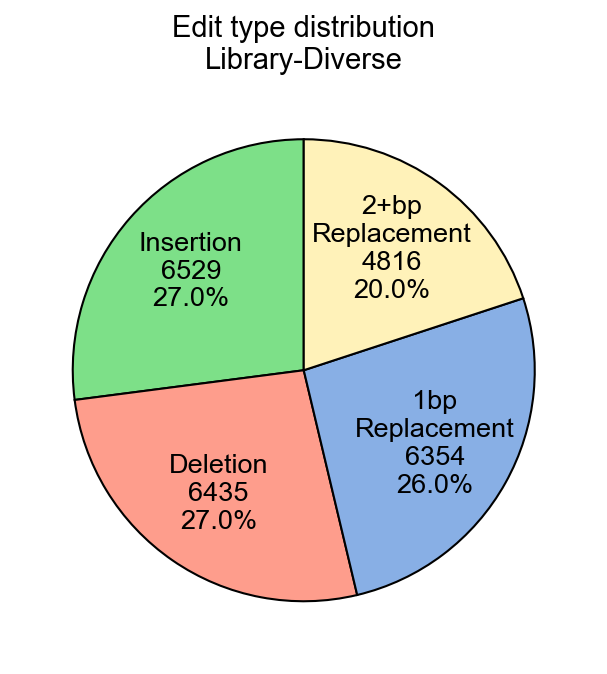

In [43]:
# Define function to calculate the absolute value, the percentage, and include the labels for the autopct
def make_autopct(values, labels):
    total = sum(values)
    return [f'{labels[i]}\n{int(round(pct*total/100.0))}\n{round(pct, 0)}%' for i, pct in enumerate(values / total * 100)]

mutation_counts = templatedf['Mutation_Type'].value_counts()

# Create the pie chart
fig16, ax16 = plt.subplots(figsize=(5, 5), dpi=150)
ax16.set_title('Edit type distribution\nLibrary-Diverse', fontsize=14)

labels = mutation_counts.index
labels = ['1bp\nReplacement' if x == '1bpReplacement' else '2+bp\nReplacement' if x == 'MultibpReplacement' else x for x in labels]
counts = mutation_counts.values
colors = ['#7de088', '#FE9D8C', '#88AFE5', '#FFF2B9']

# We pass the list of labels to our autopct function
autopct_labels = make_autopct(counts, labels)

wedges, texts, autotexts = ax16.pie(counts, colors = colors[:len(counts)], autopct=lambda pct: autopct_labels.pop(0), startangle=90, pctdistance=0.65, wedgeprops = {'linewidth': 1, 'edgecolor' : "black"},  textprops={'fontsize': 13})
plt.show()

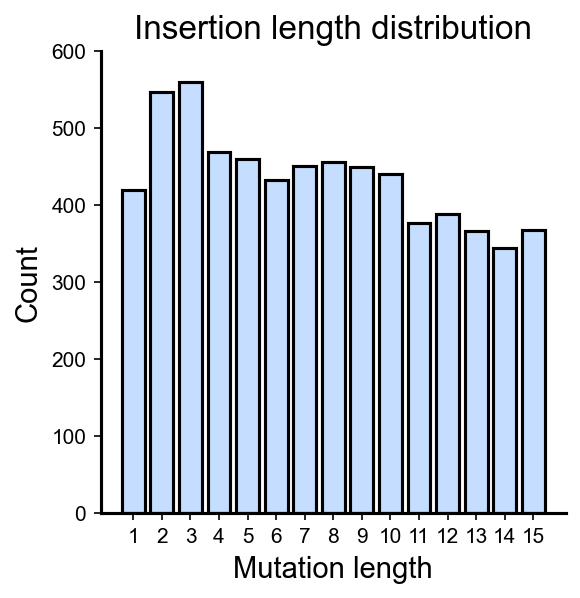

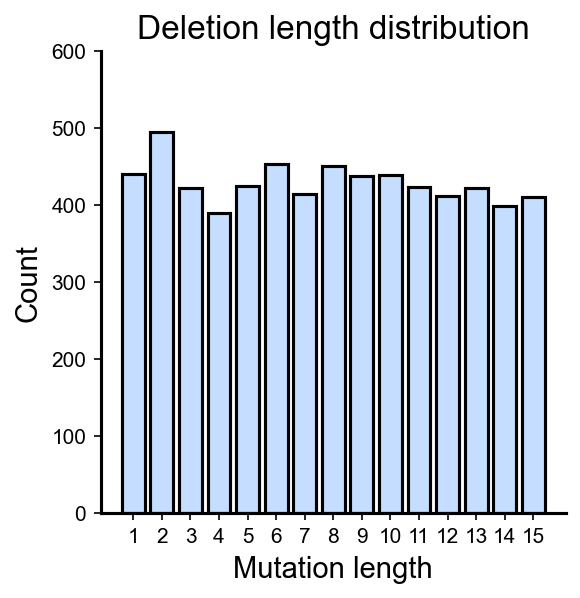

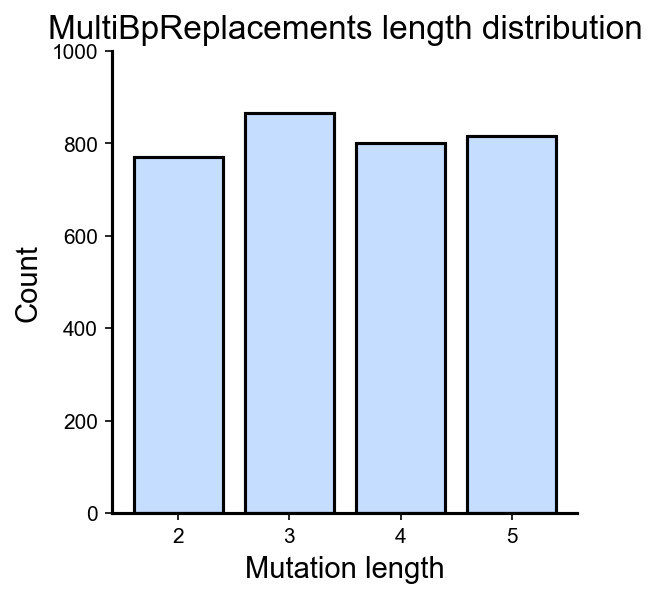

In [44]:
def plot_mutation_length_distribution(mutation_type, templatedf, title, xticks, ylimit, file_name, filter_by_name=None):
    if filter_by_name:
        mutation_df = templatedf[(templatedf['Mutation_Type'] == mutation_type) & (templatedf['Name'].str.contains(filter_by_name))]
    else:
        mutation_df = templatedf[templatedf['Mutation_Type'] == mutation_type]
    
    mutation_correctionlengthcount = Counter(mutation_df.Correction_Length)
    mutation_correctionlengthcount = OrderedDict(sorted(mutation_correctionlengthcount.items()))

    positionlist = []
    countlist = []
    for k, v in mutation_correctionlengthcount.items():
        positionlist.append(k)
        countlist.append(v)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    plt.rcParams['axes.linewidth'] = 1.5
    ax.bar(positionlist, countlist, **bar_kwargs)
    ax.set_title(title, fontsize=titlesize)
    ax.set_xlabel('Mutation length', fontsize=lsize)
    ax.set_ylabel('Count', fontsize=lsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(xticks)
    ax.set_ylim(0, ylimit)
    plt.show()

# Plot for Insertion Mutation Type
plot_mutation_length_distribution('Insertion', templatedf, 'Insertion length distribution', range(1, 16, 1), 600, 'Insertion_correctionlength_distribution.pdf')

# Plot for Deletion Mutation Type
plot_mutation_length_distribution('Deletion', templatedf, 'Deletion length distribution', range(1, 16, 1), 600, 'Deletion_correctionlength_distribution.pdf')

# Plot for MultiBpReplacements Mutation Type with "multibpreplacement" in the "Name" column
plot_mutation_length_distribution('MultibpReplacement', templatedf, 'MultiBpReplacements length distribution', range(2,6,1), 1000, 'MultiBpReplacements_correctionlength_distribution.pdf', filter_by_name='multibpreplacement')

#### Bystander editing overview

In [4]:
bystanderdfpath = '../01_Bystander_Edits/01_Library_Design/'
bystanderdf = pd.read_csv(bystanderdfpath + '20220922_6k_bystanderlibrary_with_barcodes_and_primers.csv')
bystanderdf_after_filtering = templatedf[templatedf['Name'].str.contains('_NM_')].copy()

In [5]:
def count_identical_protospacer_sequences(df, min_group_size=3):
    # Group by 'variant'
    grouped = df.groupby('variant')
    
    # Count groups where all 'Protospacer-Sequence' are identical and group size is at least min_group_size
    count = sum((group['Protospacer-Sequence'].nunique() == 1) and (len(group) == min_group_size) for _, group in grouped)
    
    return count

# Count for the initial dataframe
count_before = count_identical_protospacer_sequences(bystanderdf)
print(f'Before filtering, there are {count_before} unique variant groups with identical Protospacer-Sequences and at 3 pegRNAs.')

# Count for the dataframe after filtering
count_after = count_identical_protospacer_sequences(bystanderdf_after_filtering)
print(f'After filtering, there are {count_after} unique variant groups with identical Protospacer-Sequences and at 3 pegRNAs.')

Before filtering, there are 942 unique variant groups with identical Protospacer-Sequences and at 3 pegRNAs.
After filtering, there are 613 unique variant groups with identical Protospacer-Sequences and at 3 pegRNAs.


#### Editing comparisons 

In [68]:
def plot_correlation_bars(correlation_dict_1, correlation_dict_2, title, ylimit, label_1, label_2, xlabel):
    models, values_1 = zip(*sorted(correlation_dict_1.items()))  # Sorting based on edit lengths
    _, values_2 = zip(*sorted(correlation_dict_2.items()))

    positionlist = list(range(len(models)))
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    bar_width = 0.35
    plt.rcParams['axes.linewidth'] = 1.5

    # Colors
    color_1 = "#FEE6AC"
    color_2 = "#C5DEFF"
    edgecolor = "black"

    bars1 = ax.bar(positionlist, values_1, bar_width, label=label_1, 
                   color=color_1, edgecolor=edgecolor)
    bars2 = ax.bar([p + bar_width for p in positionlist], values_2, bar_width, label=label_2, 
                   color=color_2, edgecolor=edgecolor)

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Correlation', fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks([p + bar_width/2 for p in positionlist])
    ax.set_xticklabels(models)
    ax.set_ylim(0, ylimit)
    ax.legend()

    plt.tight_layout()
    plt.show()

Position list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Average editing list: [37.10484584854226, 37.881616018467064, 32.18016558736399, 27.557052432466673, 21.73498684317094, 15.62809897008948, 11.594806027625657, 8.105740723635886, 7.416225152024803, 5.260894070339592, 4.72023197357232, 4.999557031633316, 4.177726069491519, 3.317183122318248, 4.876269692319872]
Count editing list: [408, 519, 541, 446, 447, 416, 433, 446, 432, 424, 361, 373, 359, 332, 346]


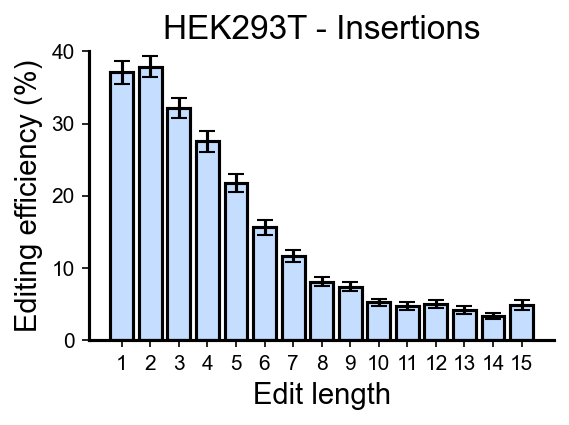

Position list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Average editing list: [6.634895871805246, 8.055448782540685, 8.184818932731057, 10.962594348449338, 9.704971576460057, 8.194174136368355, 6.49524157720681, 4.618035082504895, 4.156832727017289, 2.9949411766605447, 2.9207436139663363, 2.796801481771588, 2.2648236240466266, 1.7483717483639902, 2.9771742834618755]
Count editing list: [410, 525, 546, 445, 448, 414, 434, 444, 434, 426, 364, 375, 360, 331, 346]


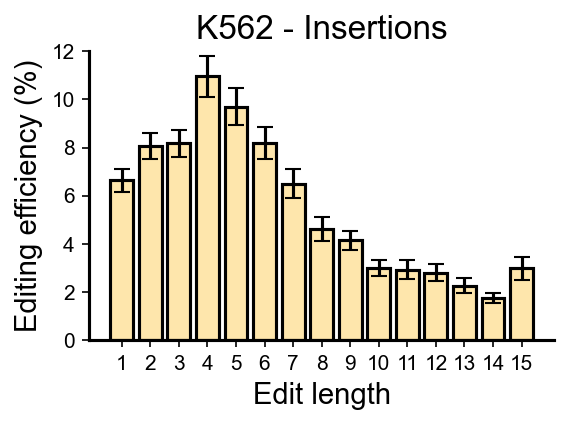

Position list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Average editing list: [30.481355852641656, 28.717724555286125, 22.341654866807325, 22.17704340289383, 14.061485409578083, 10.021061039824335, 5.28983736158424, 3.8451230849358895, 3.6899765324637848, 2.52393404877731, 2.325321581200462, 2.177373522826257, 2.1995181777118096, 1.7721168853030198, 3.261968040461079]
Count editing list: [424, 475, 388, 367, 406, 420, 380, 418, 405, 408, 391, 375, 365, 340, 362]


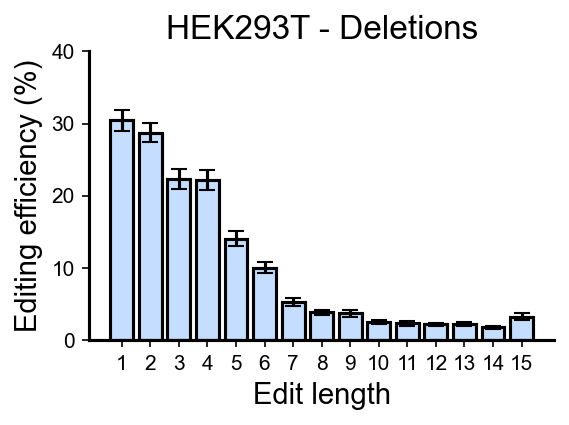

Position list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Average editing list: [1.104803626136907, 0.9194822958226478, 0.8716869110394885, 1.0364517257935129, 1.0669230864383217, 1.280877796504321, 0.9427775552534218, 1.0993609841403473, 1.0443740969478743, 1.2230807827598504, 0.9614053256936744, 0.8598165602360935, 1.0777279554972368, 0.9606978067951859, 1.11392288609371]
Count editing list: [420, 476, 394, 373, 409, 420, 385, 416, 411, 409, 391, 385, 370, 348, 366]


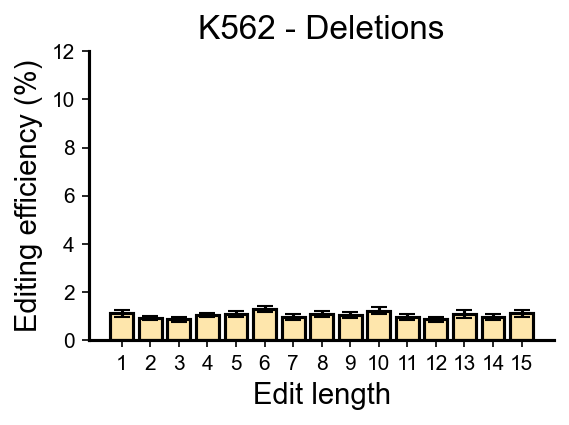

In [33]:
def plot_mutation_length_editing_distribution(cell_type, mutation_type, title, xticks, ylimit, file_name, filter_by_name=None):
    if filter_by_name:
        mutation_df = templatedf[(templatedf['Mutation_Type'] == mutation_type) & (templatedf['Name'].str.contains(filter_by_name))]
    else:
        mutation_df = templatedf[templatedf['Mutation_Type'] == mutation_type]
    
    # remove nan values
    mutation_df = mutation_df[~mutation_df[cell_type+'averageedited'].isna()]

    mutation_length_editing_dict = {}
    for index, row in mutation_df.iterrows():
        correction_length = row['Correction_Length']
        editing_rate = row[cell_type+'averageedited']
        if correction_length in mutation_length_editing_dict:
            mutation_length_editing_dict[correction_length].append(editing_rate)
        else:
            mutation_length_editing_dict[correction_length] = [editing_rate]

    count_editing_rate_dict = {}
    average_editing_rate_dict = {}
    sem_dict = {}
    for k, v in mutation_length_editing_dict.items():
        average_editing_rate_dict[k] = np.mean(v)
        count_editing_rate_dict[k] = len(v)
        sem_dict[k] = stats.sem(v)

    average_editing_rate_dict = OrderedDict(sorted(average_editing_rate_dict.items()))
    count_editing_rate_dict = OrderedDict(sorted(count_editing_rate_dict.items()))
    sem_dict = OrderedDict(sorted(sem_dict.items()))


    positionlist = []
    editinglist = []
    countlist = []
    sem_list = []
    for k, v in average_editing_rate_dict.items():
        positionlist.append(k)
        editinglist.append(v)
        countlist.append(count_editing_rate_dict[k])
        sem_list.append(sem_dict[k])
    print("Position list:", positionlist)
    print("Average editing list:", editinglist)
    print("Count editing list:", countlist)

    fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=150)
    plt.rcParams['axes.linewidth'] = 1.5

    bar_kwargs_copy = bar_kwargs.copy()
    bar_kwargs_copy['color'] = "#FEE6AC" if cell_type == "K562" else bar_kwargs['color']
    ax.bar(positionlist, editinglist, yerr=sem_list, **bar_kwargs_copy)
    ax.set_title(title, fontsize=titlesize)
    ax.set_xlabel('Edit length', fontsize=lsize)
    ax.set_ylabel('Editing efficiency (%)', fontsize=lsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(xticks)
    ax.set_ylim(0, ylimit)

    plt.show()

# Plot for Insertion Mutation Type
plot_mutation_length_editing_distribution('HEK', 'Insertion', 'HEK293T - Insertions', range(1, 16, 1), 40, 'HEK_Insertion_correctionlength_editing_distribution.pdf')
plot_mutation_length_editing_distribution('K562', 'Insertion', 'K562 - Insertions', range(1, 16, 1), 12, 'K562_Insertion_correctionlength_editing_distribution.pdf')

# Plot for Deletion Mutation Type
plot_mutation_length_editing_distribution('HEK', 'Deletion', 'HEK293T - Deletions', range(1, 16, 1), 40, 'HEK_Deletion_correctionlength_editing_distribution.pdf')
plot_mutation_length_editing_distribution('K562', 'Deletion', 'K562 - Deletions', range(1, 16, 1), 12, 'K562_Deletion_correctionlength_editing_distribution.pdf')

#### 1bp editing position - RTToverhang heatmap

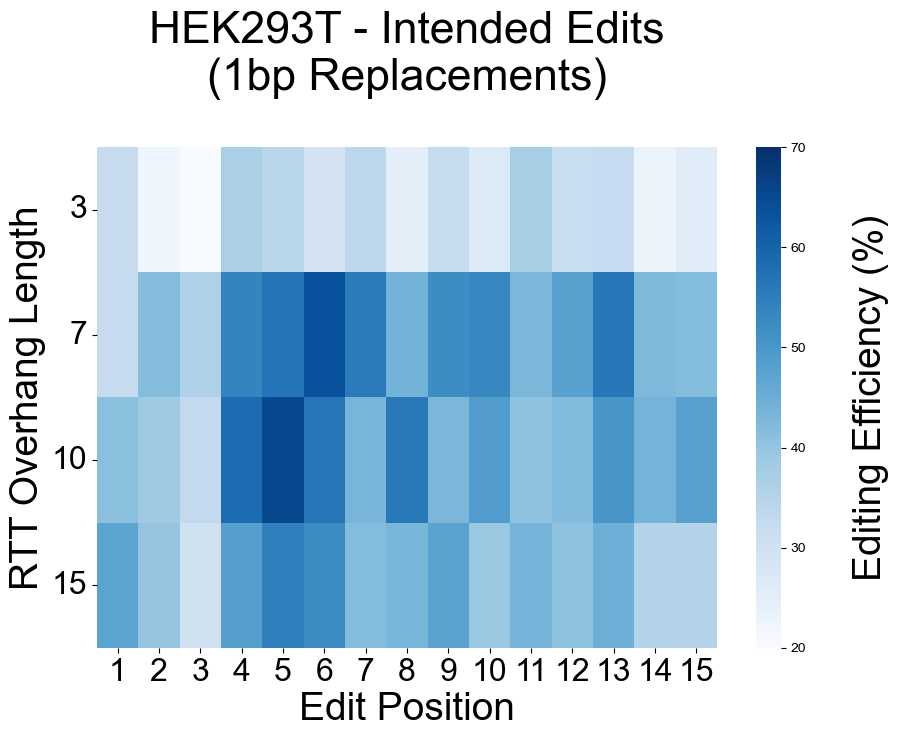

In [11]:
RToverhanglengthlist = [3,7,10,15]
editpositionlist = list(range(0,15))
RTheatmaparray = np.empty([4,15])

for editpositionindex, editposition in enumerate(editpositionlist):
    for RToverhangindex, RToverhang in enumerate(RToverhanglengthlist):
        # Adjusting the filter to 'Mutation_Type'
        # editrates = templatedf[(templatedf['Mutation_Type'] == '1bpReplacement')&(templatedf['RToverhanglength'] == RToverhang)&(templatedf['Editing_Position'] ==editposition)]['HEKaverageedited']
        editrates = templatedf[(templatedf['Name'].str.contains('singlebpreplacement'))&(templatedf['RToverhanglength'] == RToverhang)&(templatedf['Editing_Position'] ==editposition)]['HEKaverageedited']

        RTheatmaparray[RToverhangindex, editpositionindex] = editrates.mean()

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title('HEK293T - Intended Edits\n(1bp Replacements)\n', fontsize=32)
#cmap = sn.light_palette("seagreen", as_cmap=True)
cmap = sn.color_palette("Blues", as_cmap=True)
ax = sn.heatmap(RTheatmaparray,cmap=cmap,cbar_kws={'label': '\nEditing Efficiency (%)'},vmin=20, vmax=70)
ax.figure.axes[-1].yaxis.label.set_size(28)

xticks_labels = list(range(1,16))
plt.xticks(np.arange(len(editpositionlist)) + .5, labels=xticks_labels, fontsize=23)
yticks_labels = ['3','7','10','15']
plt.yticks(np.arange(4) + .5, labels=yticks_labels, rotation=0, fontsize=23)
ax.set_xlabel('Edit Position', fontsize=28)
ax.set_ylabel('RTT Overhang Length', fontsize=28)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\01_Overview_Features\\'
# plt.savefig(figurepath+'rtoverhanglength_editpos_heatmap.pdf', format='pdf',
#         transparent=True,bbox_inches='tight')
plt.show()

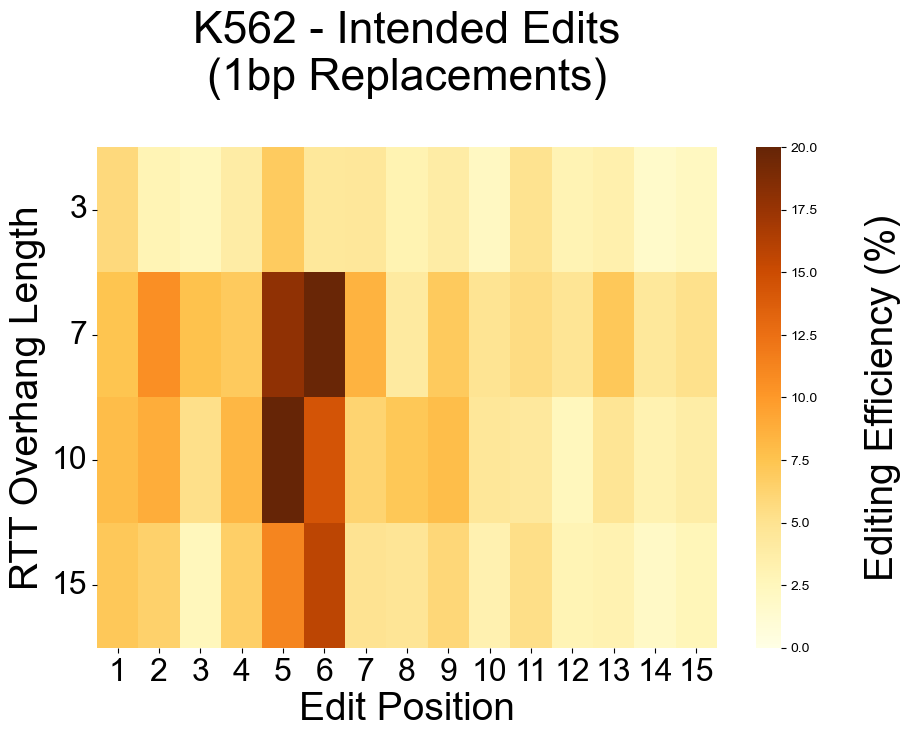

In [12]:
RToverhanglengthlist = [3,7,10,15]
editpositionlist = list(range(0,15))
RTheatmaparray = np.empty([4,15])

for editpositionindex, editposition in enumerate(editpositionlist):
    for RToverhangindex, RToverhang in enumerate(RToverhanglengthlist):
        # Adjusting the filter to 'Mutation_Type'
        # editrates = templatedf[(templatedf['Mutation_Type'] == '1bpReplacement')&(templatedf['RToverhanglength'] == RToverhang)&(templatedf['Editing_Position'] ==editposition)]['K562averageedited']
        editrates = templatedf[(templatedf['Name'].str.contains('singlebpreplacement'))&(templatedf['RToverhanglength'] == RToverhang)&(templatedf['Editing_Position'] ==editposition)]['K562averageedited']

        RTheatmaparray[RToverhangindex, editpositionindex] = editrates.mean()

fig, ax = plt.subplots(figsize=(10, 6.5))
ax.set_title('K562 - Intended Edits\n(1bp Replacements)\n', fontsize=32)
#cmap = sn.light_palette("seagreen", as_cmap=True)
cmap = sn.color_palette("YlOrBr", as_cmap=True)
ax = sn.heatmap(RTheatmaparray,cmap=cmap,cbar_kws={'label': '\nEditing Efficiency (%)'},vmin=0, vmax=20)
ax.figure.axes[-1].yaxis.label.set_size(28)

xticks_labels = list(range(1,16))
plt.xticks(np.arange(len(editpositionlist)) + .5, labels=xticks_labels, fontsize=23)
yticks_labels = ['3','7','10','15']
plt.yticks(np.arange(4) + .5, labels=yticks_labels, rotation=0, fontsize=23)
ax.set_xlabel('Edit Position', fontsize=28)
ax.set_ylabel('RTT Overhang Length', fontsize=28)
figurepath = 'C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Prime_Editing\\03_DiseaseScreen\\06_Paper_writing\\figures\\01_Overview_Features\\'
# plt.savefig(figurepath+'rtoverhanglength_editpos_heatmap.pdf', format='pdf',
#         transparent=True,bbox_inches='tight')
plt.show()

#### Replacement edit length editing distribution

No 3bp overhang to keep distribution consistent between replacement lengths (2bp replacement overrepresenting 10bp overhang otherwise)
Position list: [1, 2, 3, 4, 5]
Average editing list: [51.82857556946216, 49.242267770107155, 44.4986130288009, 41.60932803937719, 43.092360827136]
Count editing list: [5146, 834, 638, 538, 576]


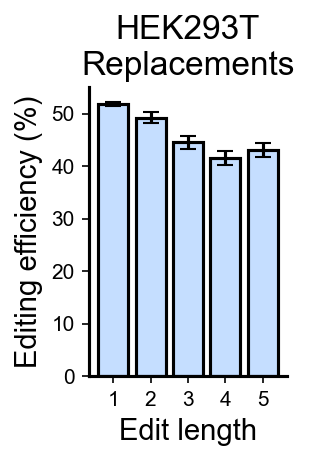

No 3bp overhang to keep distribution consistent between replacement lengths (2bp replacement overrepresenting 10bp overhang otherwise)
Position list: [1, 2, 3, 4, 5]
Average editing list: [7.754210633574587, 7.327118816318788, 11.36476634479728, 12.022580447585446, 16.774253795886064]
Count editing list: [5158, 844, 644, 554, 575]


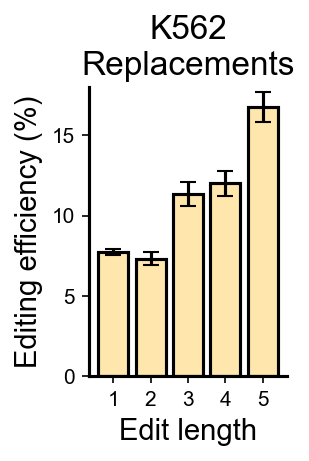

In [36]:
def plot_multireplacement_length_editing_distribution(cell_type, filtereddf, title, xticks, ylimit, file_name):
    mutation_df = filtereddf.copy()
     # remove nan values
    mutation_df = mutation_df[~mutation_df[cell_type+'averageedited'].isna()]

    mutation_length_editing_dict = {}
    for index, row in mutation_df.iterrows():
        correction_length = row['Correction_Length']
        editing_rate = row[cell_type+'averageedited']
        if correction_length in mutation_length_editing_dict:
            mutation_length_editing_dict[correction_length].append(editing_rate)
        else:
            mutation_length_editing_dict[correction_length] = [editing_rate]

    count_editing_rate_dict = {}
    average_editing_rate_dict = {}
    sem_dict = {}
    for k, v in mutation_length_editing_dict.items():
        average_editing_rate_dict[k] = np.mean(v)
        count_editing_rate_dict[k] = len(v)
        sem_dict[k] = stats.sem(v)

    average_editing_rate_dict = OrderedDict(sorted(average_editing_rate_dict.items()))
    count_editing_rate_dict = OrderedDict(sorted(count_editing_rate_dict.items()))
    sem_dict = OrderedDict(sorted(sem_dict.items()))


    positionlist = []
    editinglist = []
    countlist = []
    sem_list = []
    for k, v in average_editing_rate_dict.items():
        positionlist.append(k)
        editinglist.append(v)
        countlist.append(count_editing_rate_dict[k])
        sem_list.append(sem_dict[k])
    print('No 3bp overhang to keep distribution consistent between replacement lengths (2bp replacement overrepresenting 10bp overhang otherwise)')
    print("Position list:", positionlist)
    print("Average editing list:", editinglist)
    print("Count editing list:", countlist)

    fig, ax = plt.subplots(1, 1, figsize=(1.7, 2.5), dpi=150)
    plt.rcParams['axes.linewidth'] = 1.5


    bar_kwargs_copy = bar_kwargs.copy()
    bar_kwargs_copy['color'] = "#FEE6AC" if cell_type == "K562" else bar_kwargs['color']
    ax.bar(positionlist, editinglist, yerr=sem_list, **bar_kwargs_copy)

    ax.set_title(title, fontsize=titlesize)
    ax.set_xlabel('Edit length', fontsize=lsize)
    ax.set_ylabel('Editing efficiency (%)', fontsize=lsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(xticks)
    ax.set_ylim(0, ylimit)

    plt.show()


filtereddf = templatedf[(templatedf['Mutation_Type'] == 'MultibpReplacement') | 
                        (templatedf['Mutation_Type'] == '1bpReplacement')].copy()
filtereddf = filtereddf[filtereddf['RToverhanglength'] > 5]

# Remove rows where 'Name' column contains 'NM' and 'Correction_Length' is NOT 2, but keep those with 'Correction_Length' is 1; these are non-adjacent multibp replacements, not analyzed in this plot.
filtereddf = filtereddf[~((filtereddf['Name'].str.contains('NM')) & 
                          (filtereddf['Correction_Length'] != 2) &
                          (filtereddf['Correction_Length'] != 1))]
    
plot_multireplacement_length_editing_distribution('HEK', filtereddf, 'HEK293T\nReplacements', range(1, 6, 1), 55, 'HEK_Replacement_length_editing_distribution.pdf')
plot_multireplacement_length_editing_distribution('K562', filtereddf, 'K562\nReplacements', range(1, 6, 1), 18, 'K562_Replacement_length_editing_distribution.pdf')

In [4]:
filtered_templatedf = templatedf[(templatedf['Mutation_Type'] == 'MultibpReplacement') | 
                        (templatedf['Mutation_Type'] == '1bpReplacement')].copy()
filtered_templatedf = filtered_templatedf[filtered_templatedf['RToverhanglength'] > 5]

# Remove rows where 'Name' does NOT contain 'NM' and 'Correction_Length' is more than 2; these are non-adjacent multibp replacements, not analyzed in this plot.
filtered_templatedf = filtered_templatedf[~((~filtered_templatedf['Name'].str.contains('NM')) & 
                          (filtered_templatedf['Correction_Length'] > 2))]

for index, row in filtered_templatedf.iterrows():
    if row['Mutation_Type'] == '1bpReplacement':
        filtered_templatedf.at[index, 'edit1pos'] = int(row.deepeditposition - 25)
        filtered_templatedf.at[index, 'edit1_2_distance'] = 0
    elif row['Mutation_Type'] == 'MultibpReplacement':
        filtered_templatedf.at[index, 'edit1pos'] = int(row.deepeditposition_intermediate_individual[0] - 25)
        filtered_templatedf.at[index, 'edit1_2_distance'] = int(row.deepeditposition_intermediate_individual[1] - row.deepeditposition_intermediate_individual[0])

filtered_templatedf[['Mutation_Type', 'Editing_Position', 'deepeditposition', 'deepeditposition_intermediate_individual', 'edit1pos', 'edit1_2_distance']]

,Mutation_Type,Editing_Position,deepeditposition,deepeditposition_intermediate_individual,edit1pos,edit1_2_distance
0,1bpReplacement,13,39.0,[],14.0,0.0
2,1bpReplacement,3,29.0,[],4.0,0.0
3,1bpReplacement,9,35.0,[],10.0,0.0
4,1bpReplacement,9,35.0,[],10.0,0.0
5,1bpReplacement,5,31.0,[],6.0,0.0
...,...,...,...,...,...,...
24129,MultibpReplacement,9,35.0,"[35, 38]",10.0,3.0
24130,MultibpReplacement,13,39.0,"[39, 41]",14.0,2.0
24131,MultibpReplacement,10,36.0,"[36, 43]",11.0,7.0
24132,MultibpReplacement,10,36.0,"[36, 43]",11.0,7.0


Distance list: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Average editing list: [49.242267770107155, 57.23558143243994, 47.873847776875024, 57.36634100580855, 49.38958589588503, 61.94904744837553, 47.9682276548612, 56.58526521217202, 53.001192843664505, 49.041999845100705]
Count editing list: [834, 153, 71, 191, 136, 27, 141, 155, 26, 185]


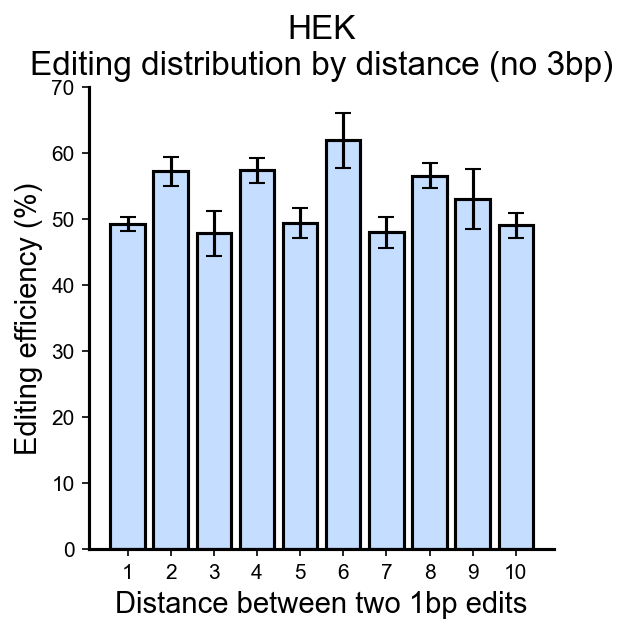

Distance list: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Average editing list: [7.327118816318788, 9.674862196139575, 3.9249260944513855, 6.997041009158425, 3.855529750309828, 4.150059562672265, 4.742647488116017, 6.0161064167993175, 3.49787947261381, 4.126989865669577]
Count editing list: [844, 150, 71, 186, 137, 31, 142, 162, 28, 193]


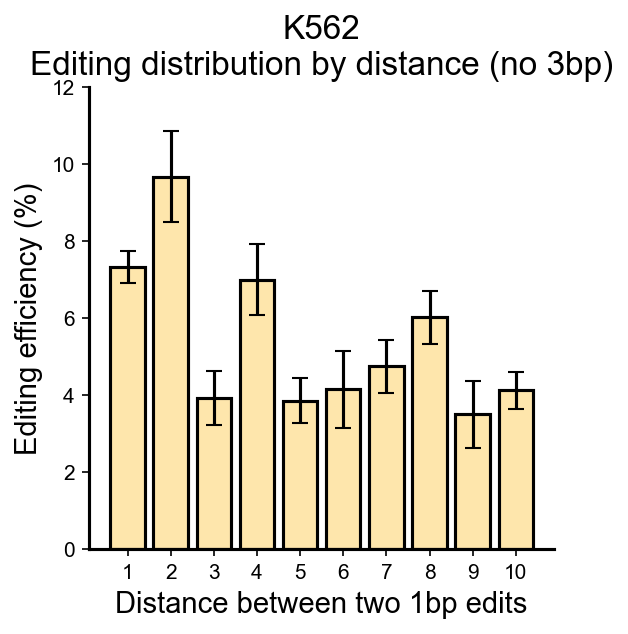

Distance list: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Average editing list: [0.1647820206422577, 0.31909872475280804, 0.488634224502348, 1.02087274498203, 2.433971068002511, 2.387272033263192, 3.981773127673371, 4.913619722427117, 7.007526120247176, 6.482827830678869]
Count editing list: [834, 153, 71, 191, 136, 27, 141, 155, 26, 185]


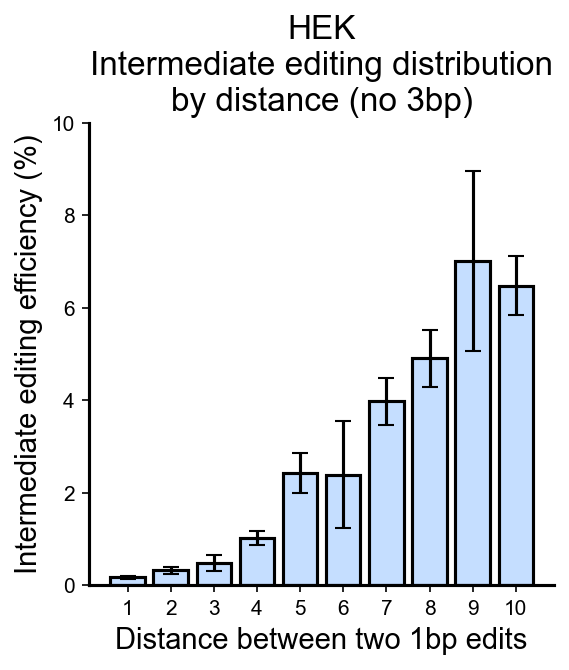

Distance list: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Average editing list: [0.5859976185556212, 1.4469045713281834, 0.8976924532500937, 2.5953962738027503, 2.4141840837893214, 1.8762261525977237, 3.2118622809867152, 3.1244334268336607, 1.619835693335705, 2.1275475568855504]
Count editing list: [844, 150, 71, 186, 137, 31, 142, 162, 28, 193]


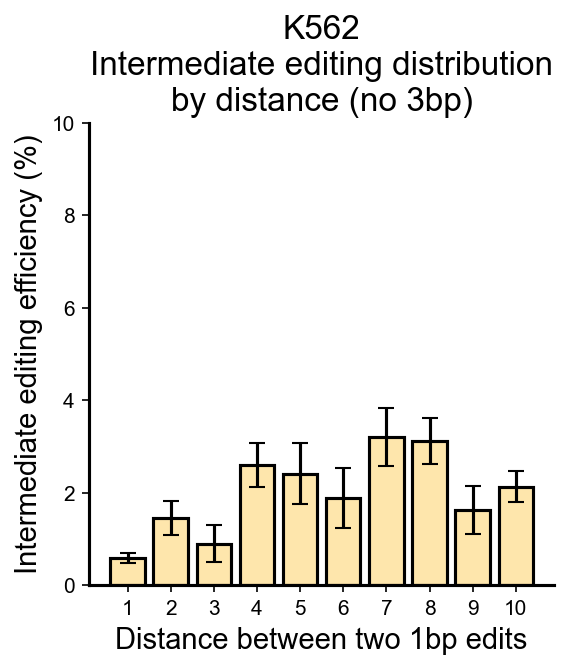

In [5]:
def plot_distance_editing_distribution(cell_type, filtered_templatedf,plotcolumn, ytitle, title, xticks, ylimit, file_name):
    mutation_df = filtered_templatedf.copy()

    # remove nan values
    mutation_df = mutation_df[~mutation_df[plotcolumn].isna()]

    distance_editing_dict = {}
    for index, row in mutation_df.iterrows():
        distance = row['edit1_2_distance']
        editing_rate = row[plotcolumn]
        if distance in distance_editing_dict:
            distance_editing_dict[distance].append(editing_rate)
        else:
            distance_editing_dict[distance] = [editing_rate]
            
    distance_editing_dict = {k: v for k, v in distance_editing_dict.items() if k > 0}

    count_editing_rate_dict = {}
    average_editing_rate_dict = {}
    sem_dict = {}
    for k, v in distance_editing_dict.items():
        average_editing_rate_dict[k] = np.mean(v)
        count_editing_rate_dict[k] = len(v)
        sem_dict[k] = stats.sem(v)

    average_editing_rate_dict = OrderedDict(sorted(average_editing_rate_dict.items()))
    count_editing_rate_dict = OrderedDict(sorted(count_editing_rate_dict.items()))
    sem_dict = OrderedDict(sorted(sem_dict.items()))

    distancelist = []
    editinglist = []
    countlist = []
    sem_list = []
    for k, v in average_editing_rate_dict.items():
        distancelist.append(k)
        editinglist.append(v)
        countlist.append(count_editing_rate_dict[k])
        sem_list.append(sem_dict[k])
    print("Distance list:", distancelist)
    print("Average editing list:", editinglist)
    print("Count editing list:", countlist)

    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
    plt.rcParams['axes.linewidth'] = 1.5

    bar_kwargs_copy = bar_kwargs.copy()
    bar_kwargs_copy['color'] = "#FEE6AC" if cell_type == "K562" else bar_kwargs['color']
    ax.bar(distancelist, editinglist, yerr=sem_list, **bar_kwargs_copy)


    ax.set_title(cell_type + '\n' + title, fontsize=titlesize)
    ax.set_xlabel('Distance between two 1bp edits', fontsize=lsize)
    ax.set_ylabel(ytitle, fontsize=lsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(xticks)
    ax.set_ylim(0, ylimit)

    plt.show()


# Run the function
plot_distance_editing_distribution('HEK', filtered_templatedf, 'HEKaverageedited', 'Editing efficiency (%)', 'Editing distribution by distance (no 3bp)', range(1, 11, 1), 70, 'HEK_Distance_editing_distribution.pdf')
plot_distance_editing_distribution('K562', filtered_templatedf, 'K562averageedited', 'Editing efficiency (%)', 'Editing distribution by distance (no 3bp)', range(1, 11, 1), 12, 'K562_Distance_editing_distribution.pdf')

# plot_distance_editing_distribution('HEK', filtered_templatedf, 'HEKaverageedited', 'Editing efficiency (%)', 'Editing distribution by distance (no 3bp)', range(0, 11, 1), 70, 'HEK_Distance_editing_distribution.pdf')

plot_distance_editing_distribution('HEK', filtered_templatedf, 'HEKaverageintermediate', 'Intermediate editing efficiency (%)', 'Intermediate editing distribution\nby distance (no 3bp)', range(1, 11, 1), 10, 'HEK_Distance_intermediting_distribution.pdf')
plot_distance_editing_distribution('K562', filtered_templatedf, 'K562averageintermediate', 'Intermediate editing efficiency (%)', 'Intermediate editing distribution\nby distance (no 3bp)', range(1, 11, 1), 10, 'K562_Distance_intermediting_distribution.pdf')



Distance list: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Average editing list: [46.62592235699697, 54.634455805899584, 46.16601933905271, 55.489426190333205, 49.99906795507817, 60.64559219608416, 47.697829353977774, 54.163843935199246, 50.62017785474751, 47.71294382184218]
Count editing list: [700, 134, 65, 170, 116, 20, 126, 132, 24, 167]


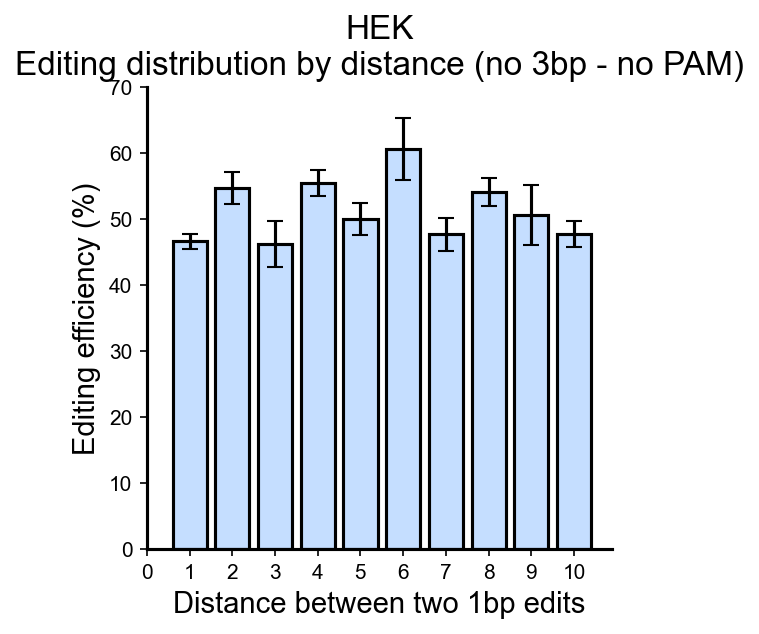

Distance list: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
Average editing list: [6.066994800445472, 7.584489304811016, 3.548613709384703, 5.250715823207954, 3.834287369821671, 3.764417376875723, 4.336068214583673, 4.929413318389377, 2.7457163411577428, 3.5041351508051632]
Count editing list: [710, 131, 65, 166, 116, 24, 127, 139, 26, 175]


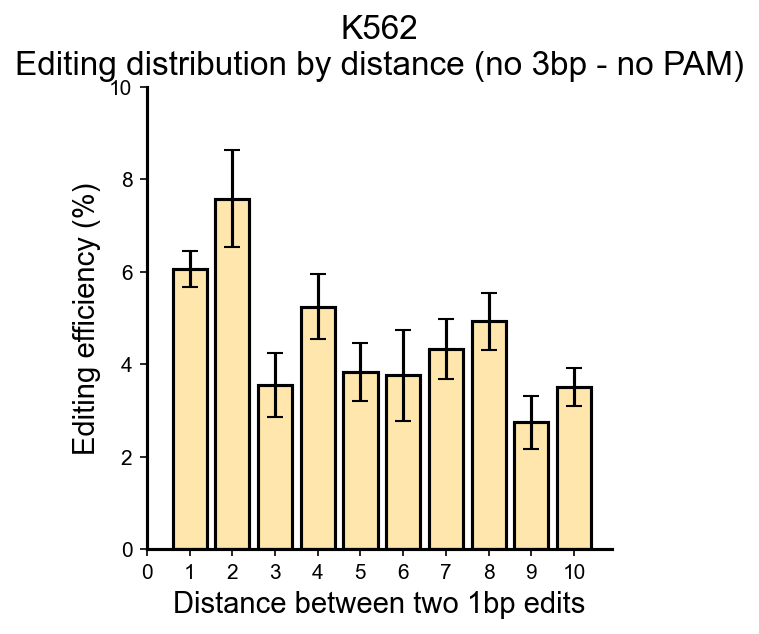

In [6]:
#make a no PAM edit filtered dataframe where we remove all edits that are in the PAM region (those where Distance between two edits + Editing_Position = 4 or 5 and also all those which have Editing_Position of 4 and 5)
filtered_templatedf_noPAM = filtered_templatedf.copy()

filtered_templatedf_noPAM = filtered_templatedf_noPAM[~((filtered_templatedf_noPAM['edit1_2_distance'] + filtered_templatedf_noPAM['Editing_Position'] == 4) | (filtered_templatedf_noPAM['edit1_2_distance'] + filtered_templatedf_noPAM['Editing_Position'] == 5))]
filtered_templatedf_noPAM = filtered_templatedf_noPAM[~((filtered_templatedf_noPAM['Editing_Position'] == 4) | (filtered_templatedf_noPAM['Editing_Position'] == 5))]


# Run the function
plot_distance_editing_distribution('HEK', filtered_templatedf_noPAM, 'HEKaverageedited', 'Editing efficiency (%)', 'Editing distribution by distance (no 3bp - no PAM)', range(0, 11, 1), 70, 'HEK_Distance_editing_distribution.pdf')
plot_distance_editing_distribution('K562', filtered_templatedf_noPAM, 'K562averageedited', 'Editing efficiency (%)','Editing distribution by distance (no 3bp - no PAM)', range(0, 11, 1), 10, 'K562_Distance_editing_distribution.pdf')


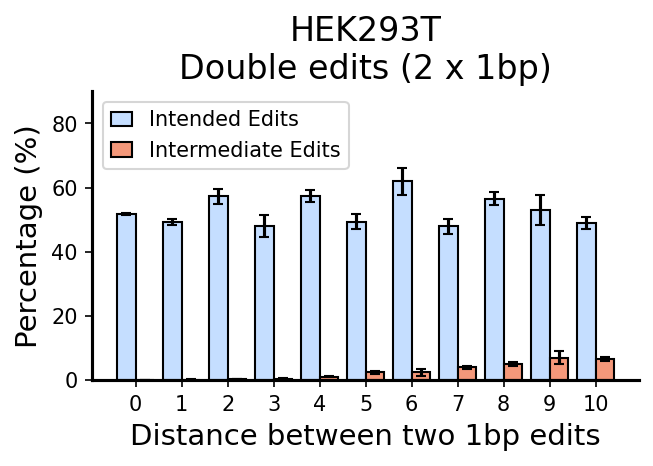

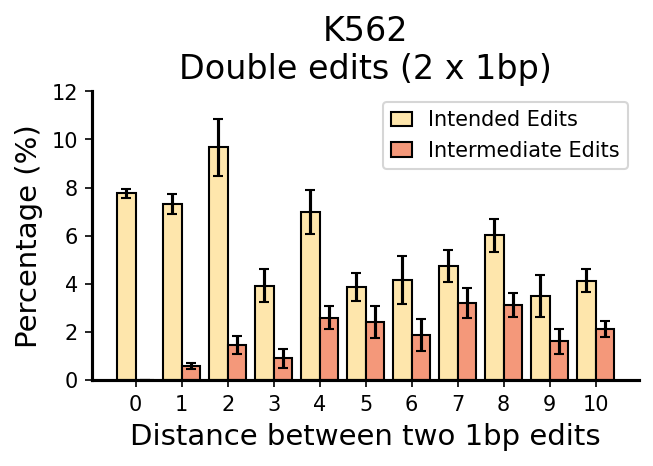

In [9]:
def plot_percentage_vs_distance_barchart(cell_type, dataframe, title, average_edited_col, average_unintended_col, percentage_intermediate_col, max_y_axis, legend_position='upper right'):
    sn.reset_defaults()

    if cell_type == 'HEK':
        colors = ['#C5DEFF','#DDDCDC', '#F4987A']
    elif cell_type == 'K562':
        colors = ['#FEE6AC','#DDDCDC', '#F4987A']

    # Define fontsize for title and labels
    titlesize = 16
    lsize = 14

    # Define tick label size
    tick_label_size = 10

    # Filter out rows where any of the three columns has NaN
    dataframe = dataframe.dropna(subset=[average_edited_col, average_unintended_col, percentage_intermediate_col])

    # Data for plotting
    average_edited = []
    average_unintended = []
    average_intermediate = []
    yerr_edited = []
    yerr_unintended = []
    yerr_intermediate = []
    num_elements = []

    # Extract data for each distance, including 1bpReplacement as distance 0
    for i in range(0, 11):
        if i == 0:
            tempdf = dataframe[dataframe['Mutation_Type'] == '1bpReplacement']
        else:
            tempdf = dataframe[(dataframe['Mutation_Type'] == 'MultibpReplacement') & (dataframe['distance_deepeditpositions'] == i)]
            
        average_edited.append(tempdf[average_edited_col].mean())
        average_unintended.append(tempdf[average_unintended_col].mean())
        average_intermediate.append(tempdf[percentage_intermediate_col].mean())
        yerr_edited.append(stats.sem(tempdf[average_edited_col]))
        yerr_unintended.append(stats.sem(tempdf[average_unintended_col]))
        yerr_intermediate.append(stats.sem(tempdf[percentage_intermediate_col]))
        num_elements.append(tempdf.shape[0])

    # Bar width
    bar_width = 0.4

    # Positions of bars
    positions_1 = np.arange(len(average_edited))
    positions_intermediate = [x + bar_width for x in positions_1]
    plt.figure(figsize=(4.7,2.5), dpi=150)

    capsize_value = 2.5
    # Average Edited
    bars1 = plt.bar(positions_1, average_edited, color=colors[0], width=bar_width, edgecolor='black', label='Intended Edits')
    plt.errorbar(positions_1, average_edited, yerr=yerr_edited, fmt='none', ecolor='black', capsize=capsize_value, barsabove=True, zorder=2)

    # Average Intermediate
    bars3 = plt.bar(positions_intermediate, average_intermediate, color=colors[2], width=bar_width, edgecolor='black', label='Intermediate Edits')
    plt.errorbar(positions_intermediate, average_intermediate, yerr=yerr_intermediate, fmt='none', ecolor='black', capsize=capsize_value, barsabove=True, zorder=2)


    # Adding x-axis labels
    plt.xlabel('Distance between two 1bp edits', fontsize=lsize)
    plt.ylabel('Percentage (%)', fontsize=lsize)
    plt.xticks([r + bar_width/2 for r in range(len(average_edited))], range(0, 11), fontsize=tick_label_size)

    # Adding legend
    plt.legend(loc=legend_position,handlelength=1)

    # Title
    plt.title(title, fontsize=titlesize)

     # Get the current axes, creating them if necessary:
    ax = plt.gca()

    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set linewidth of the spines
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Adjust thickness of axis ticks
    ax.tick_params(axis='both', which='major', labelsize=tick_label_size)

    # Set maximum y-axis limit
    plt.ylim(0, max_y_axis)

    # Show plot
    plt.show()
plot_percentage_vs_distance_barchart('HEK', filtered_templatedf, 'HEK293T\nDouble edits (2 x 1bp)', 'HEKaverageedited', 'HEKaverageunintended', 'HEKaverageintermediate', 90, legend_position='upper left')
plot_percentage_vs_distance_barchart('K562', filtered_templatedf, 'K562\nDouble edits (2 x 1bp)','K562averageedited', 'K562averageunintended', 'K562averageintermediate', 12)


#### Replicate correlations

22619


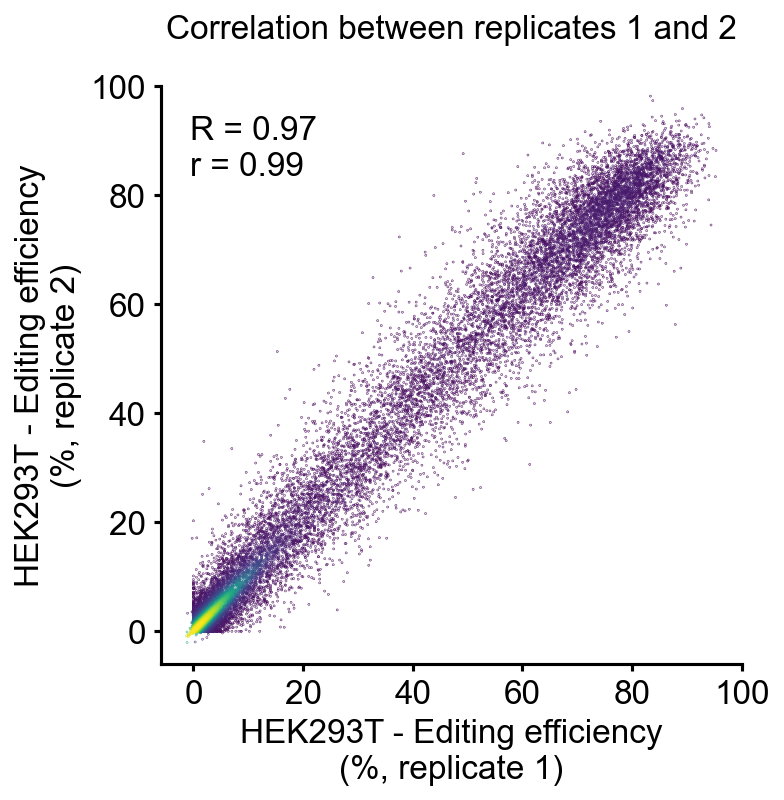

22619


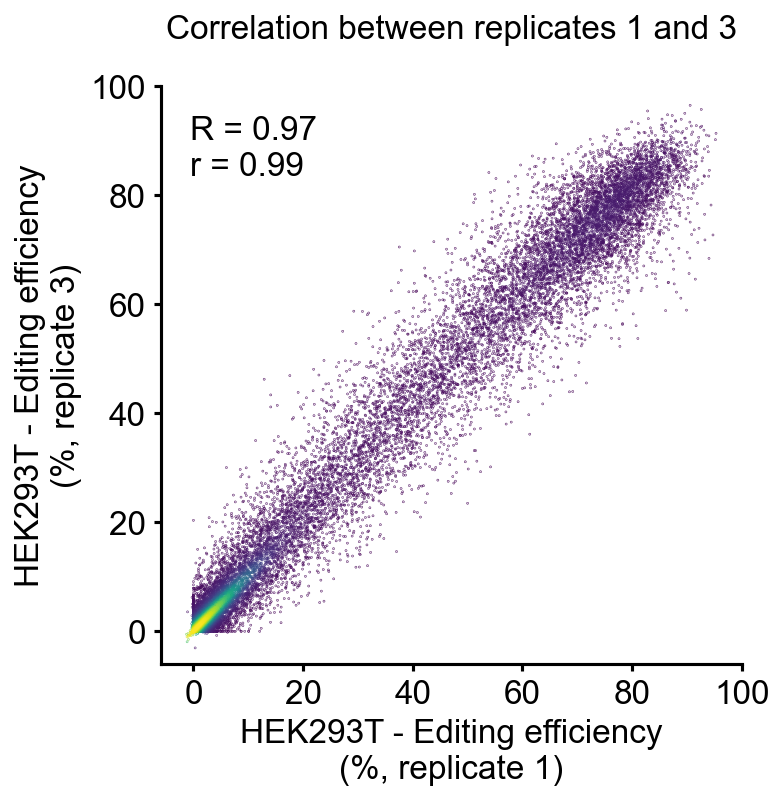

22619


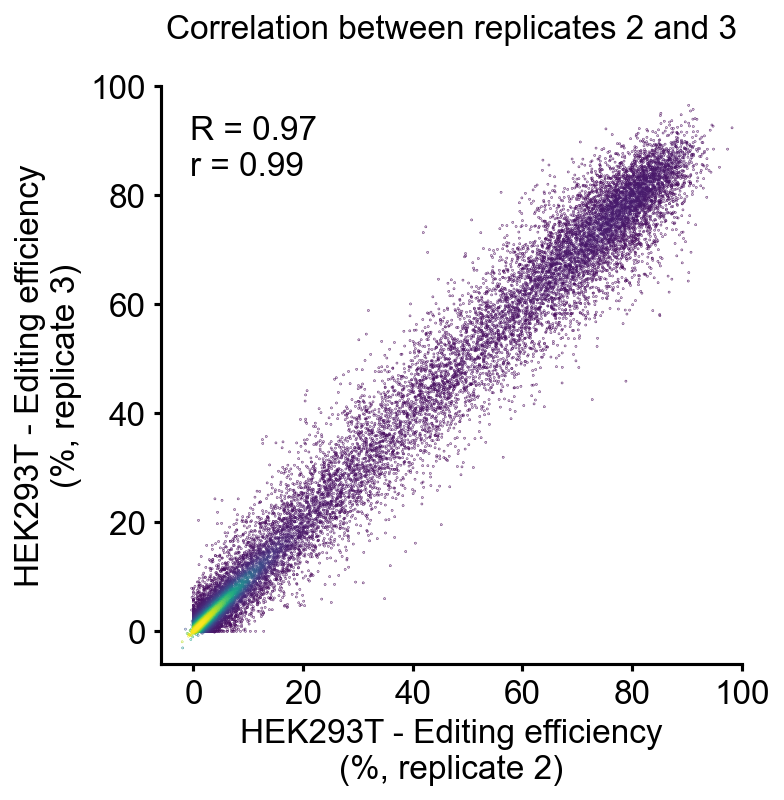

In [4]:
def create_correlation_plot(rep_a_eff, rep_b_eff, rep_a_label, rep_b_label, title=None):
    xy = np.vstack([rep_a_eff, rep_b_eff])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    Correlation_x, Correlation_y, Correlation_z = rep_a_eff[idx], rep_b_eff[idx], z[idx]
    R = stats.spearmanr(rep_a_eff, rep_b_eff)[0]
    r = stats.pearsonr(rep_a_eff, rep_b_eff)[0]
    print(len(Correlation_x))
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    ax.scatter(Correlation_x, Correlation_y, c=Correlation_z, s=0.05)
    ax.tick_params(axis='x', labelsize=16, width=1.5)
    ax.tick_params(axis='y', labelsize=16, width=1.5)
    ax.set_xlabel(rep_a_label, fontsize=16)
    ax.set_ylabel(rep_b_label, fontsize=16)
    ax.set_xlim(-6, 100)
    ax.set_ylim(-6, 100)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.text(0.05, 0.95, f'R = {R:.2f}\nr = {r:.2f}', transform=ax.transAxes, fontsize=16, verticalalignment='top')
    if title:
        ax.set_title(title, fontsize=16)

    figurepath = 'path/to/your/desired/directory/'
    plt.show()


interested_columns = ['HEK_PE2_1_percentageedited_corrected_individual',
                      'HEK_PE2_2_percentageedited_corrected_individual',
                      'HEK_PE2_3_percentageedited_corrected_individual']

clean_templatedf = templatedf.dropna(subset=interested_columns)

rep1eff = clean_templatedf['HEK_PE2_1_percentageedited_corrected_individual'].reset_index(drop=True)
rep2eff = clean_templatedf['HEK_PE2_2_percentageedited_corrected_individual'].reset_index(drop=True)
rep3eff = clean_templatedf['HEK_PE2_3_percentageedited_corrected_individual'].reset_index(drop=True)

create_correlation_plot(rep1eff, rep2eff, 'HEK293T - Editing efficiency\n(%, replicate 1)', 'HEK293T - Editing efficiency\n(%, replicate 2)', 'Correlation between replicates 1 and 2\n')
create_correlation_plot(rep1eff, rep3eff, 'HEK293T - Editing efficiency\n(%, replicate 1)', 'HEK293T - Editing efficiency\n(%, replicate 3)', 'Correlation between replicates 1 and 3\n')
create_correlation_plot(rep2eff, rep3eff, 'HEK293T - Editing efficiency\n(%, replicate 2)', 'HEK293T - Editing efficiency\n(%, replicate 3)', 'Correlation between replicates 2 and 3\n')

22752


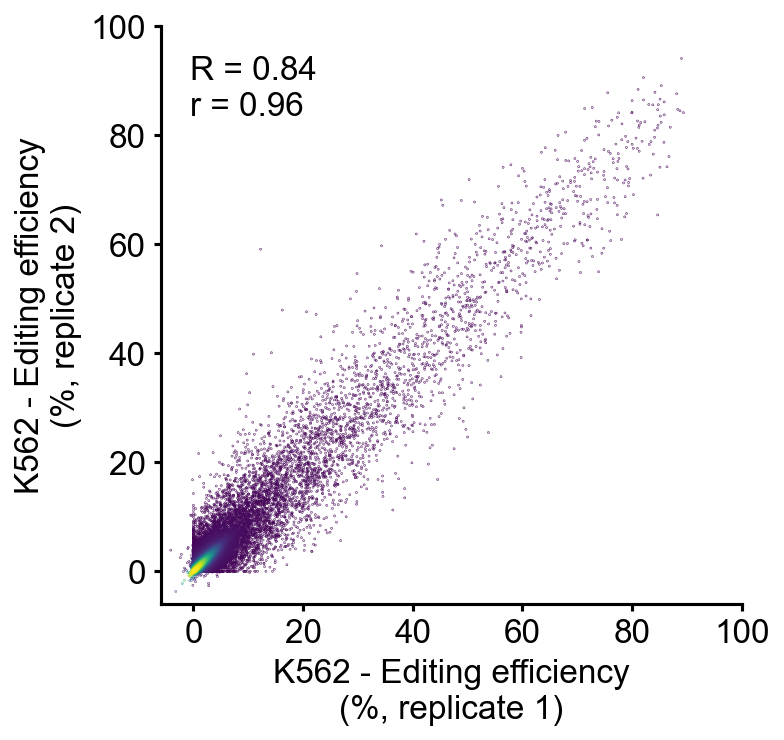

22752


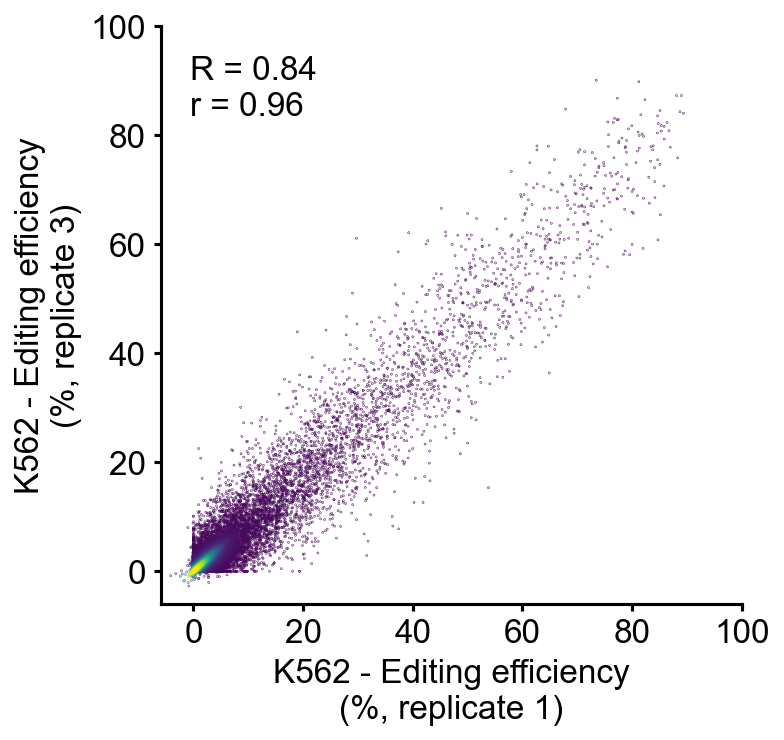

22752


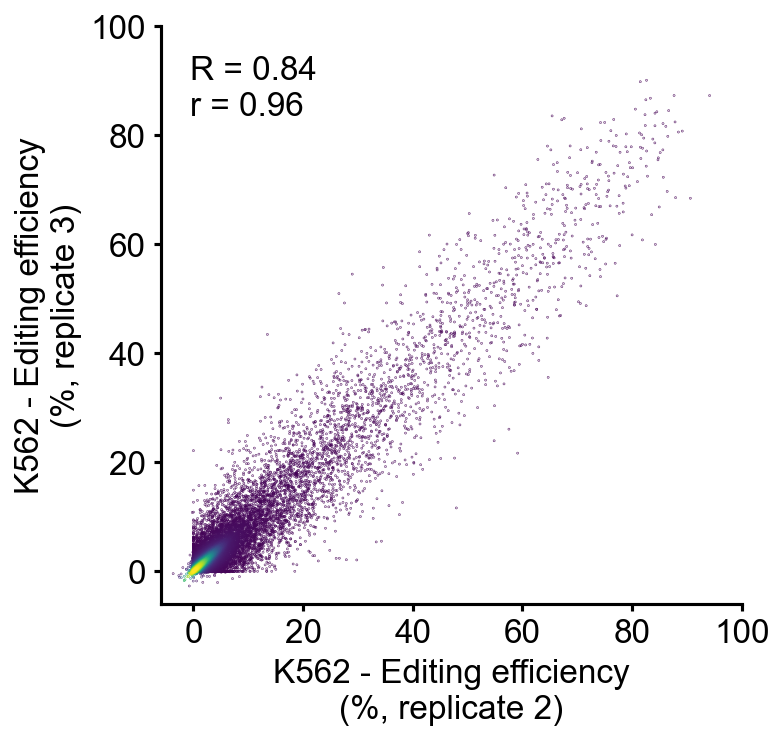

In [6]:
interested_columns = ['K562_PE2_1_percentageedited_corrected_individual',
                      'K562_PE2_2_percentageedited_corrected_individual',
                      'K562_PE2_3_percentageedited_corrected_individual']

clean_templatedf = templatedf.dropna(subset=interested_columns)

rep1eff = clean_templatedf['K562_PE2_1_percentageedited_corrected_individual'].reset_index(drop=True)
rep2eff = clean_templatedf['K562_PE2_2_percentageedited_corrected_individual'].reset_index(drop=True)
rep3eff = clean_templatedf['K562_PE2_3_percentageedited_corrected_individual'].reset_index(drop=True)

create_correlation_plot(rep1eff, rep2eff, 'K562 - Editing efficiency\n(%, replicate 1)', 'K562 - Editing efficiency\n(%, replicate 2)')
create_correlation_plot(rep1eff, rep3eff, 'K562 - Editing efficiency\n(%, replicate 1)', 'K562 - Editing efficiency\n(%, replicate 3)')
create_correlation_plot(rep2eff, rep3eff, 'K562 - Editing efficiency\n(%, replicate 2)', 'K562 - Editing efficiency\n(%, replicate 3)')

#### Double editing - intended editing overview

1919


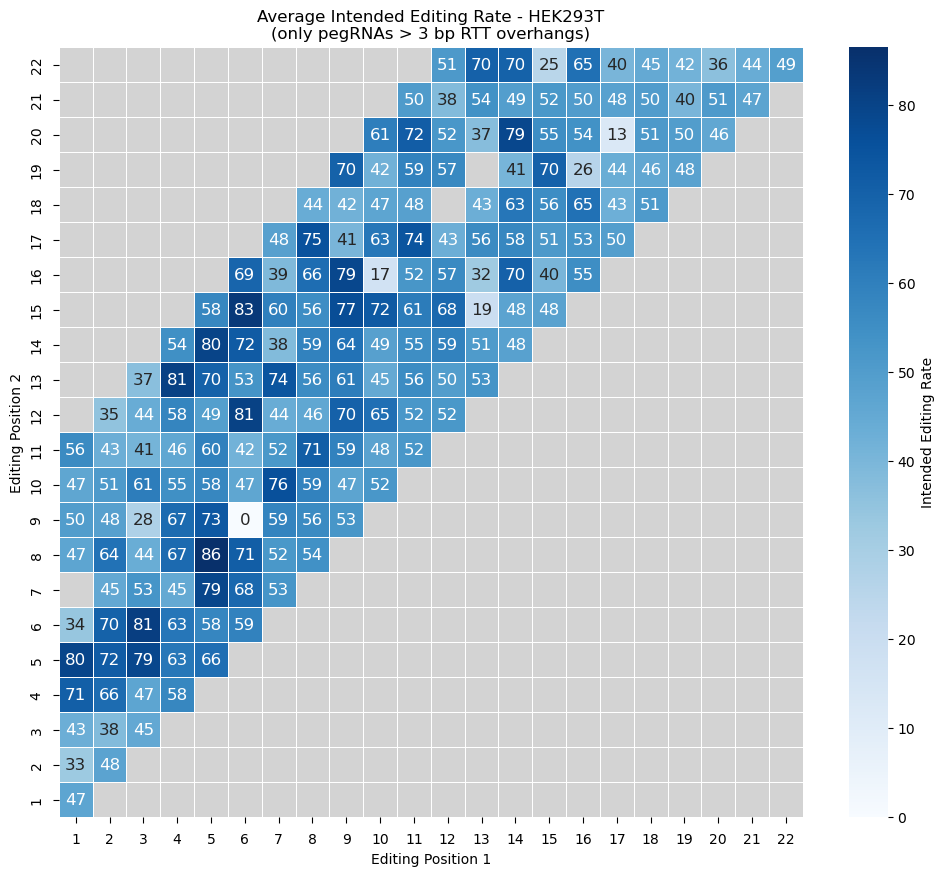

In [14]:
import seaborn as sns


# Define the size of the matrix
position_size = 22

# Create a new DataFrame by filtering out rows with NaN values in 'HEKaverageedited'
filtered_templatedf = templatedf.dropna(subset=['HEKaverageedited'])
filtered_templatedf = filtered_templatedf[filtered_templatedf['RToverhanglength'] >3]

# Filter the new DataFrame
single_replacements = filtered_templatedf[filtered_templatedf['Mutation_Type'] == '1bpReplacement']
# Get rows that have 'NM' in the name and are 'MultibpReplacement'
condition1 = (filtered_templatedf['Name'].str.contains('NM')) & (filtered_templatedf['Mutation_Type'] == 'MultibpReplacement')

# Get rows that don't have 'NM' in the name, are 'MultibpReplacement', and have a length of 2 in the 'deepeditposition_intermediate' column
condition2 = (~filtered_templatedf['Name'].str.contains('NM')) & (filtered_templatedf['Mutation_Type'] == 'MultibpReplacement') & (filtered_templatedf['Correction_Length'] == 2)

# Combine both conditions using the OR operator
dual_edits = filtered_templatedf[condition1 | condition2]


print(len(dual_edits))

# Create empty matrices of size position_size x position_size for the heatmap
sum_heatmap_data = np.zeros((position_size, position_size))
count_heatmap_data = np.zeros((position_size, position_size))

# Update the matrices with single replacement editing rates
for _, row in single_replacements.iterrows():
    position = int(row['deepeditposition'] - 25)
    sum_heatmap_data[position - 1][position - 1] += row['HEKaverageedited']
    count_heatmap_data[position - 1][position - 1] += 1

# Update the matrices with dual edit editing rates
for _, row in dual_edits.iterrows():
    positions = [int(p) - 25 for p in row['deepeditposition_intermediate_individual']]
    sum_heatmap_data[positions[0] - 1][positions[1] - 1] += row['HEKaverageedited']
    sum_heatmap_data[positions[1] - 1][positions[0] - 1] += row['HEKaverageedited']
    count_heatmap_data[positions[0] - 1][positions[1] - 1] += 1
    count_heatmap_data[positions[1] - 1][positions[0] - 1] += 1




# Calculate average editing rate and set NaN for positions with no data
average_heatmap_data = np.divide(sum_heatmap_data, count_heatmap_data, out=np.full_like(sum_heatmap_data, np.nan), where=count_heatmap_data != 0)

# Create a mask for NaN values
nan_mask = np.isnan(average_heatmap_data)

# Creating an upper triangular mask including the main diagonal
triangle_mask = np.triu(np.ones_like(average_heatmap_data, dtype=bool), k=1)

# Combine triangle_mask and nan_mask using the OR operator
final_mask = np.logical_or(triangle_mask, nan_mask)

# Create a heatmap
fig, ax = plt.subplots(figsize=(12, 10))
cax = sns.heatmap(average_heatmap_data, annot=True, fmt='.0f', cmap='Blues', linewidths=0.5, ax=ax, mask=final_mask, cbar_kws={'label': 'Intended Editing Rate'}, annot_kws={"size": 12})

# Set the color for NaN values
cax.set_facecolor('lightgrey')

# Center the ticks for the x and y axis
ax.tick_params(axis='both', which='both', length=4, labelsize=10, pad=7)
ax.set_xticks(np.arange(0.5, position_size, 1))
ax.set_yticks(np.arange(0.5, position_size, 1))
ax.set_xticklabels(range(1, position_size + 1))
ax.set_yticklabels(range(1, position_size + 1))
ax.set_xlabel('Editing Position 1')
ax.set_ylabel('Editing Position 2')
ax.set_title('Average Intended Editing Rate - HEK293T\n(only pegRNAs > 3 bp RTT overhangs)')

ax.invert_yaxis()
plt.show()

Number of rows for Single (not in PAM): 4606
Number of rows for Single (in PAM): 474
Number of rows for Double (none in PAM): 2818
Number of rows for Double (min. 1 in PAM): 820


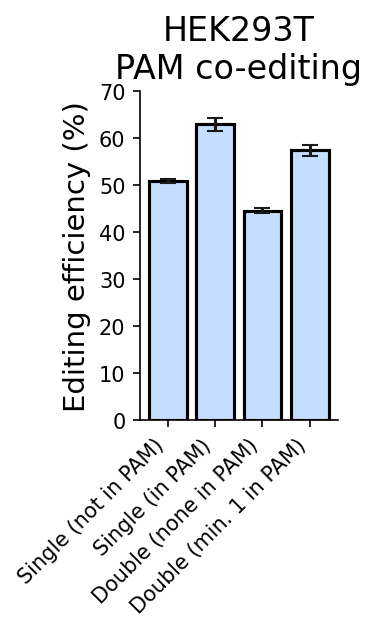

Number of rows for Single (not in PAM): 4606
Number of rows for Single (in PAM): 474
Number of rows for Double (none in PAM): 2818
Number of rows for Double (min. 1 in PAM): 820


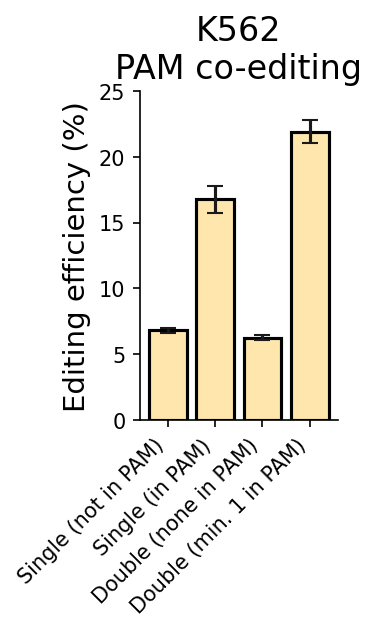

In [22]:

def plot_pam_vs_non_pam_barplot(cell_type, filtered_templatedf, plotcolumn, ytitle, title, xticks, ylimit, file_name, bar_colors=None):

    # Initialize an empty list to store the average efficiencies for each category
    average_efficiencies = []
    sem_list = []
    n_values = []  # Initialize an empty list to store the 'n' values for each category

    categories = [
        ('Single (not in PAM)', lambda row: row['Mutation_Type'] == '1bpReplacement' and row['deepeditposition'] not in [30, 31]),
        ('Single (in PAM)', lambda row: row['Mutation_Type'] == '1bpReplacement' and row['deepeditposition'] in [30, 31]),
        ('Double (none in PAM)', lambda row: row['Mutation_Type'] == 'MultibpReplacement' and all(pos not in [30, 31] for pos in row['deepeditposition_intermediate_individual'])),
        ('Double (min. 1 in PAM)', lambda row: row['Mutation_Type'] == 'MultibpReplacement' and any(pos in [30, 31] for pos in row['deepeditposition_intermediate_individual']))
    ]

    for label, condition in categories:
        subset = filtered_templatedf[filtered_templatedf.apply(condition, axis=1)]
        print(f"Number of rows for {label}: {len(subset)}")  # Print the number of rows for each category
        average_efficiency = subset[plotcolumn].mean()
        sem = stats.sem(subset[plotcolumn].dropna())
        average_efficiencies.append(average_efficiency)
        sem_list.append(sem)
        n_values.append(len(subset))  # Count of rows for each bar

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(1.7, 2.85), dpi=150)
     # Create a local copy of bar_kwargs
    local_bar_kwargs = bar_kwargs.copy()
    
    # Update the local copy with the provided colors if bar_colors is not None
    if bar_colors is not None:
        local_bar_kwargs.update({'color': bar_colors})
    
    bars = ax.bar(xticks, average_efficiencies, yerr=sem_list, **local_bar_kwargs)

    ax.set_title(title, fontsize=titlesize)
    # ax.set_xlabel('Category', fontsize=lsize)
    ax.set_ylabel(ytitle, fontsize=lsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks(xticks)
    ax.set_xticklabels([label for label, _ in categories], rotation=45, ha='right')
    ax.set_ylim(0, ylimit)

    # Uncomment the next line if you want to save the figure
    plt.savefig(file_name, format='pdf', transparent=True, bbox_inches='tight')
    plt.show()


# Create a new DataFrame by filtering out rows with NaN values in 'HEKaverageedited'
filtered_templatedf_HEK_K562 = templatedf.dropna(subset=['HEKaverageedited', 'K562averageedited'])
filtered_templatedf_HEK_K562 = filtered_templatedf_HEK_K562[filtered_templatedf_HEK_K562['RToverhanglength'] >3]


plot_pam_vs_non_pam_barplot('HEK', filtered_templatedf_HEK_K562, 'HEKaverageedited', 'Editing efficiency (%)', 'HEK293T\nPAM co-editing', range(4), 70, 'HEK_PAM_co_editing.pdf')
plot_pam_vs_non_pam_barplot('K562', filtered_templatedf_HEK_K562, 'K562averageedited', 'Editing efficiency (%)', 'K562\nPAM co-editing', range(4), 25, 'K562_PAM_co_editing.pdf',"#FEE6AC")

2139


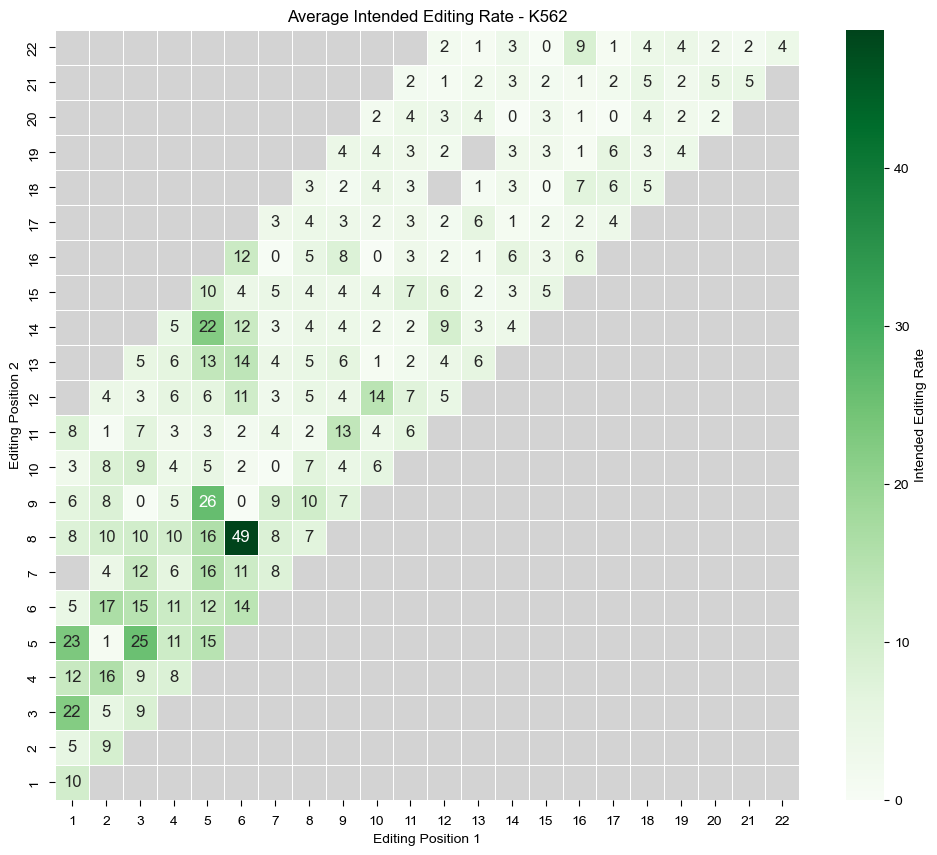

In [32]:
import seaborn as sns


# Define the size of the matrix
position_size = 22

# Create a new DataFrame by filtering out rows with NaN values in 'HEKaverageedited'
filtered_templatedf = templatedf.dropna(subset=['K562averageedited'])

# Filter the new DataFrame
single_replacements = filtered_templatedf[filtered_templatedf['Mutation_Type'] == '1bpReplacement']
# Get rows that have 'NM' in the name and are 'MultibpReplacement'
condition1 = (filtered_templatedf['Name'].str.contains('NM')) & (filtered_templatedf['Mutation_Type'] == 'MultibpReplacement')

# Get rows that don't have 'NM' in the name, are 'MultibpReplacement', and have a length of 2 in the 'deepeditposition_intermediate' column
condition2 = (~filtered_templatedf['Name'].str.contains('NM')) & (filtered_templatedf['Mutation_Type'] == 'MultibpReplacement') & (filtered_templatedf['Correction_Length'] == 2)

# Combine both conditions using the OR operator
dual_edits = filtered_templatedf[condition1 | condition2]


print(len(dual_edits))

# Create empty matrices of size position_size x position_size for the heatmap
sum_heatmap_data = np.zeros((position_size, position_size))
count_heatmap_data = np.zeros((position_size, position_size))

# Update the matrices with single replacement editing rates
for _, row in single_replacements.iterrows():
    position = int(row['deepeditposition'] - 25)
    sum_heatmap_data[position - 1][position - 1] += row['K562averageedited']
    count_heatmap_data[position - 1][position - 1] += 1

# Update the matrices with dual edit editing rates
for _, row in dual_edits.iterrows():
    positions = [int(p) - 25 for p in row['deepeditposition_intermediate_individual']]
    sum_heatmap_data[positions[0] - 1][positions[1] - 1] += row['K562averageedited']
    sum_heatmap_data[positions[1] - 1][positions[0] - 1] += row['K562averageedited']
    count_heatmap_data[positions[0] - 1][positions[1] - 1] += 1
    count_heatmap_data[positions[1] - 1][positions[0] - 1] += 1




# Calculate average editing rate and set NaN for positions with no data
average_heatmap_data = np.divide(sum_heatmap_data, count_heatmap_data, out=np.full_like(sum_heatmap_data, np.nan), where=count_heatmap_data != 0)

# Create a mask for NaN values
nan_mask = np.isnan(average_heatmap_data)

# Creating an upper triangular mask including the main diagonal
triangle_mask = np.triu(np.ones_like(average_heatmap_data, dtype=bool), k=1)

# Combine triangle_mask and nan_mask using the OR operator
final_mask = np.logical_or(triangle_mask, nan_mask)

# Create a heatmap
fig, ax = plt.subplots(figsize=(12, 10))
cax = sns.heatmap(average_heatmap_data, annot=True, fmt='.0f', cmap='Greens', linewidths=0.5, ax=ax, mask=final_mask, cbar_kws={'label': 'Intended Editing Rate'}, annot_kws={"size": 12})

# Set the color for NaN values
cax.set_facecolor('lightgrey')

# Center the ticks for the x and y axis
ax.tick_params(axis='both', which='both', length=4, labelsize=10, pad=7)
ax.set_xticks(np.arange(0.5, position_size, 1))
ax.set_yticks(np.arange(0.5, position_size, 1))
ax.set_xticklabels(range(1, position_size + 1))
ax.set_yticklabels(range(1, position_size + 1))
ax.set_xlabel('Editing Position 1')
ax.set_ylabel('Editing Position 2')
ax.set_title('Average Intended Editing Rate - K562')

ax.invert_yaxis()
plt.show()

#### Create featuredf for ML

In [26]:
templatedf[['OriginalAllele', 'EditedAllele','wide_initial_target','wide_mutated_target','Correction_Length','deepeditposition']]
# make deepeditposition to integer
templatedf['deepeditposition'] = templatedf['deepeditposition'].astype(int)

In [73]:

featuredf_initial = templatedf.copy()
editvalue = 'HEKaverageedited'

cols = ['group','RToverhanglength', 'RTlength','Correction_Type',
        'Correction_Length', 'Editing_Position',
        'polytvalues', 'polygvalues', 'polyavalues', 'polycvalues',
        'Spacer_GC_content', 'Extension_GC_content', 'RT_GC_content',
        'PBS_GC_content','original_GC_content','edited_GC_content','RToverhangmatches','RTmt', 'RToverhangmt', 'PBSmt',
        'protospacermt','extensionmt','original_base_mt','edited_base_mt','basebefore',
        'baseafter', 'nickbasebefore', 'nickbaseafter','nickbasebeforeafter','flapbasebefore',
        'flapbaseafter', 'basebeforeafter','spacerbase_1', 'spacerbase_2', 'spacerbase_3',
        'spacerbase_4', 'spacerbase_5', 'spacerbase_6', 'spacerbase_7',
        'spacerbase_8', 'spacerbase_9', 'spacerbase_10', 'spacerbase_11',
        'spacerbase_12', 'spacerbase_13', 'spacerbase_14', 'spacerbase_15',
        'spacerbase_16', 'spacerbase_17', 'spacerbase_18', 'spacerbase_19']

HEKeditcols = ['HEKaverageedited','HEKaverageunedited','HEKaverageunintended']
K562editcols = ['K562averageedited','K562averageunedited','K562averageunintended']

additional_features = ['deepcas9','MFE_protospacer', 'MFE_protospacer_scaffold', 'MFE_extension', 'MFE_extension_scaffold', 'MFE_protospacer_extension_scaffold', 'MFE_rt', 'MFE_pbs','MFE_extension_tevopreQ1', 'MFE_protospacer_extension_scaffold_tevopreQ1']

finalcols = cols + additional_features + HEKeditcols + K562editcols

featuredf = featuredf_initial[finalcols].copy()
#featuredf = featuredf.dropna()

featuredf.to_csv('./dataframes/20230709_featuredf_451.csv', index=False)